In [1]:
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
feature_columns = [ 'Volume of aeration tanks (m3)', 'Actual Inf rate (m3/d)', '℃ Temp.Max.SamplingDate', '℃ Temp.Avg.SamplingDate', '℃ Temp.Min.SamplingDate', '℃ Dew.Max.SamplingDate',
 '℃ Dew.Avg.SamplingDate', '℃ Dew.Min.SamplingDate', '℃ Humidity.Max.SamplingDate', '℃ Humidity.Min.SamplingDate', '℃ Wind.Max.SamplingDate', '℃ Wind.Min.SamplingDate',
 '℃ Pressure.Max.SamplingDate', '℃ Pressure.Min.SamplingDate', '℃ Precipitation.SamplingDate', '℃ Temp.Max.WeekMean', '℃ Temp.Avg.WeekMean', '℃ Temp.Min.WeekMean',
 '℃ Dew.Max.WeekMean', '℃ Dew.Avg.WeekMean', '℃ Dew.Min.WeekMean', '℃ Humidity.Max.WeekMean', '℃ Humidity.Min.WeekMean', '℃ Wind.Max.WeekMean', '℃ Wind.Min.WeekMean',
 '℃ Pressure.Max.WeekMean', '℃ Pressure.Min.WeekMean', '℃ Precipitation.WeekMean', '℃ Temp.Max.WeekMax', '℃ Temp.Avg.WeekMax', '℃ Temp.Min.WeekMax', '℃ Dew.Max.WeekMax',
 '℃ Dew.Avg.WeekMax', '℃ Dew.Min.WeekMax', '℃ Humidity.Max.WeekMax', '℃ Humidity.Min.WeekMax', '℃ Wind.Max.WeekMax', '℃ Wind.Min.WeekMax', '℃ Pressure.Max.WeekMax',
 '℃ Pressure.Min.WeekMax', '℃ Precipitation.WeekMax', '℃ Precipitation.WeekAccum', '℃ Precipitation.MonthAccum', '℃ Ambient temperature (℃)', 
 'COD (mg/l) In', 'BOD7 (mg/l) In', 'NH3 (mg/L) In', 'Total Nitrogen (mg/L) In', 
 'Total Phosphorus (mg/L) In', 'pH AS', 'DO (mg/L) AS', 'Temp (oC) AS', 'MLSS (mg/l) AS', 'MLVSS (mg/l) AS', 'SVI (ml/g) AS',
 'SRT (days)', 'Precip (inch)', 'Recycle ratio (total return sludge flow/total influent flow)', 
   'Position_enc', 'Country_enc', 'City_enc', 'Plant_enc', 'Year', 'Month', 'Day', 'Weekday', ]

target_column = [ 'COD Removal Rate (mg/L/h)']

In [3]:
original_df = pd.read_csv("../0. Data/modelling_data_250326.csv")
original_df = original_df.fillna(original_df.mean())
original_df = original_df.drop(columns=["Recycle ratio (total return sludge flow/total influent flow).1"])


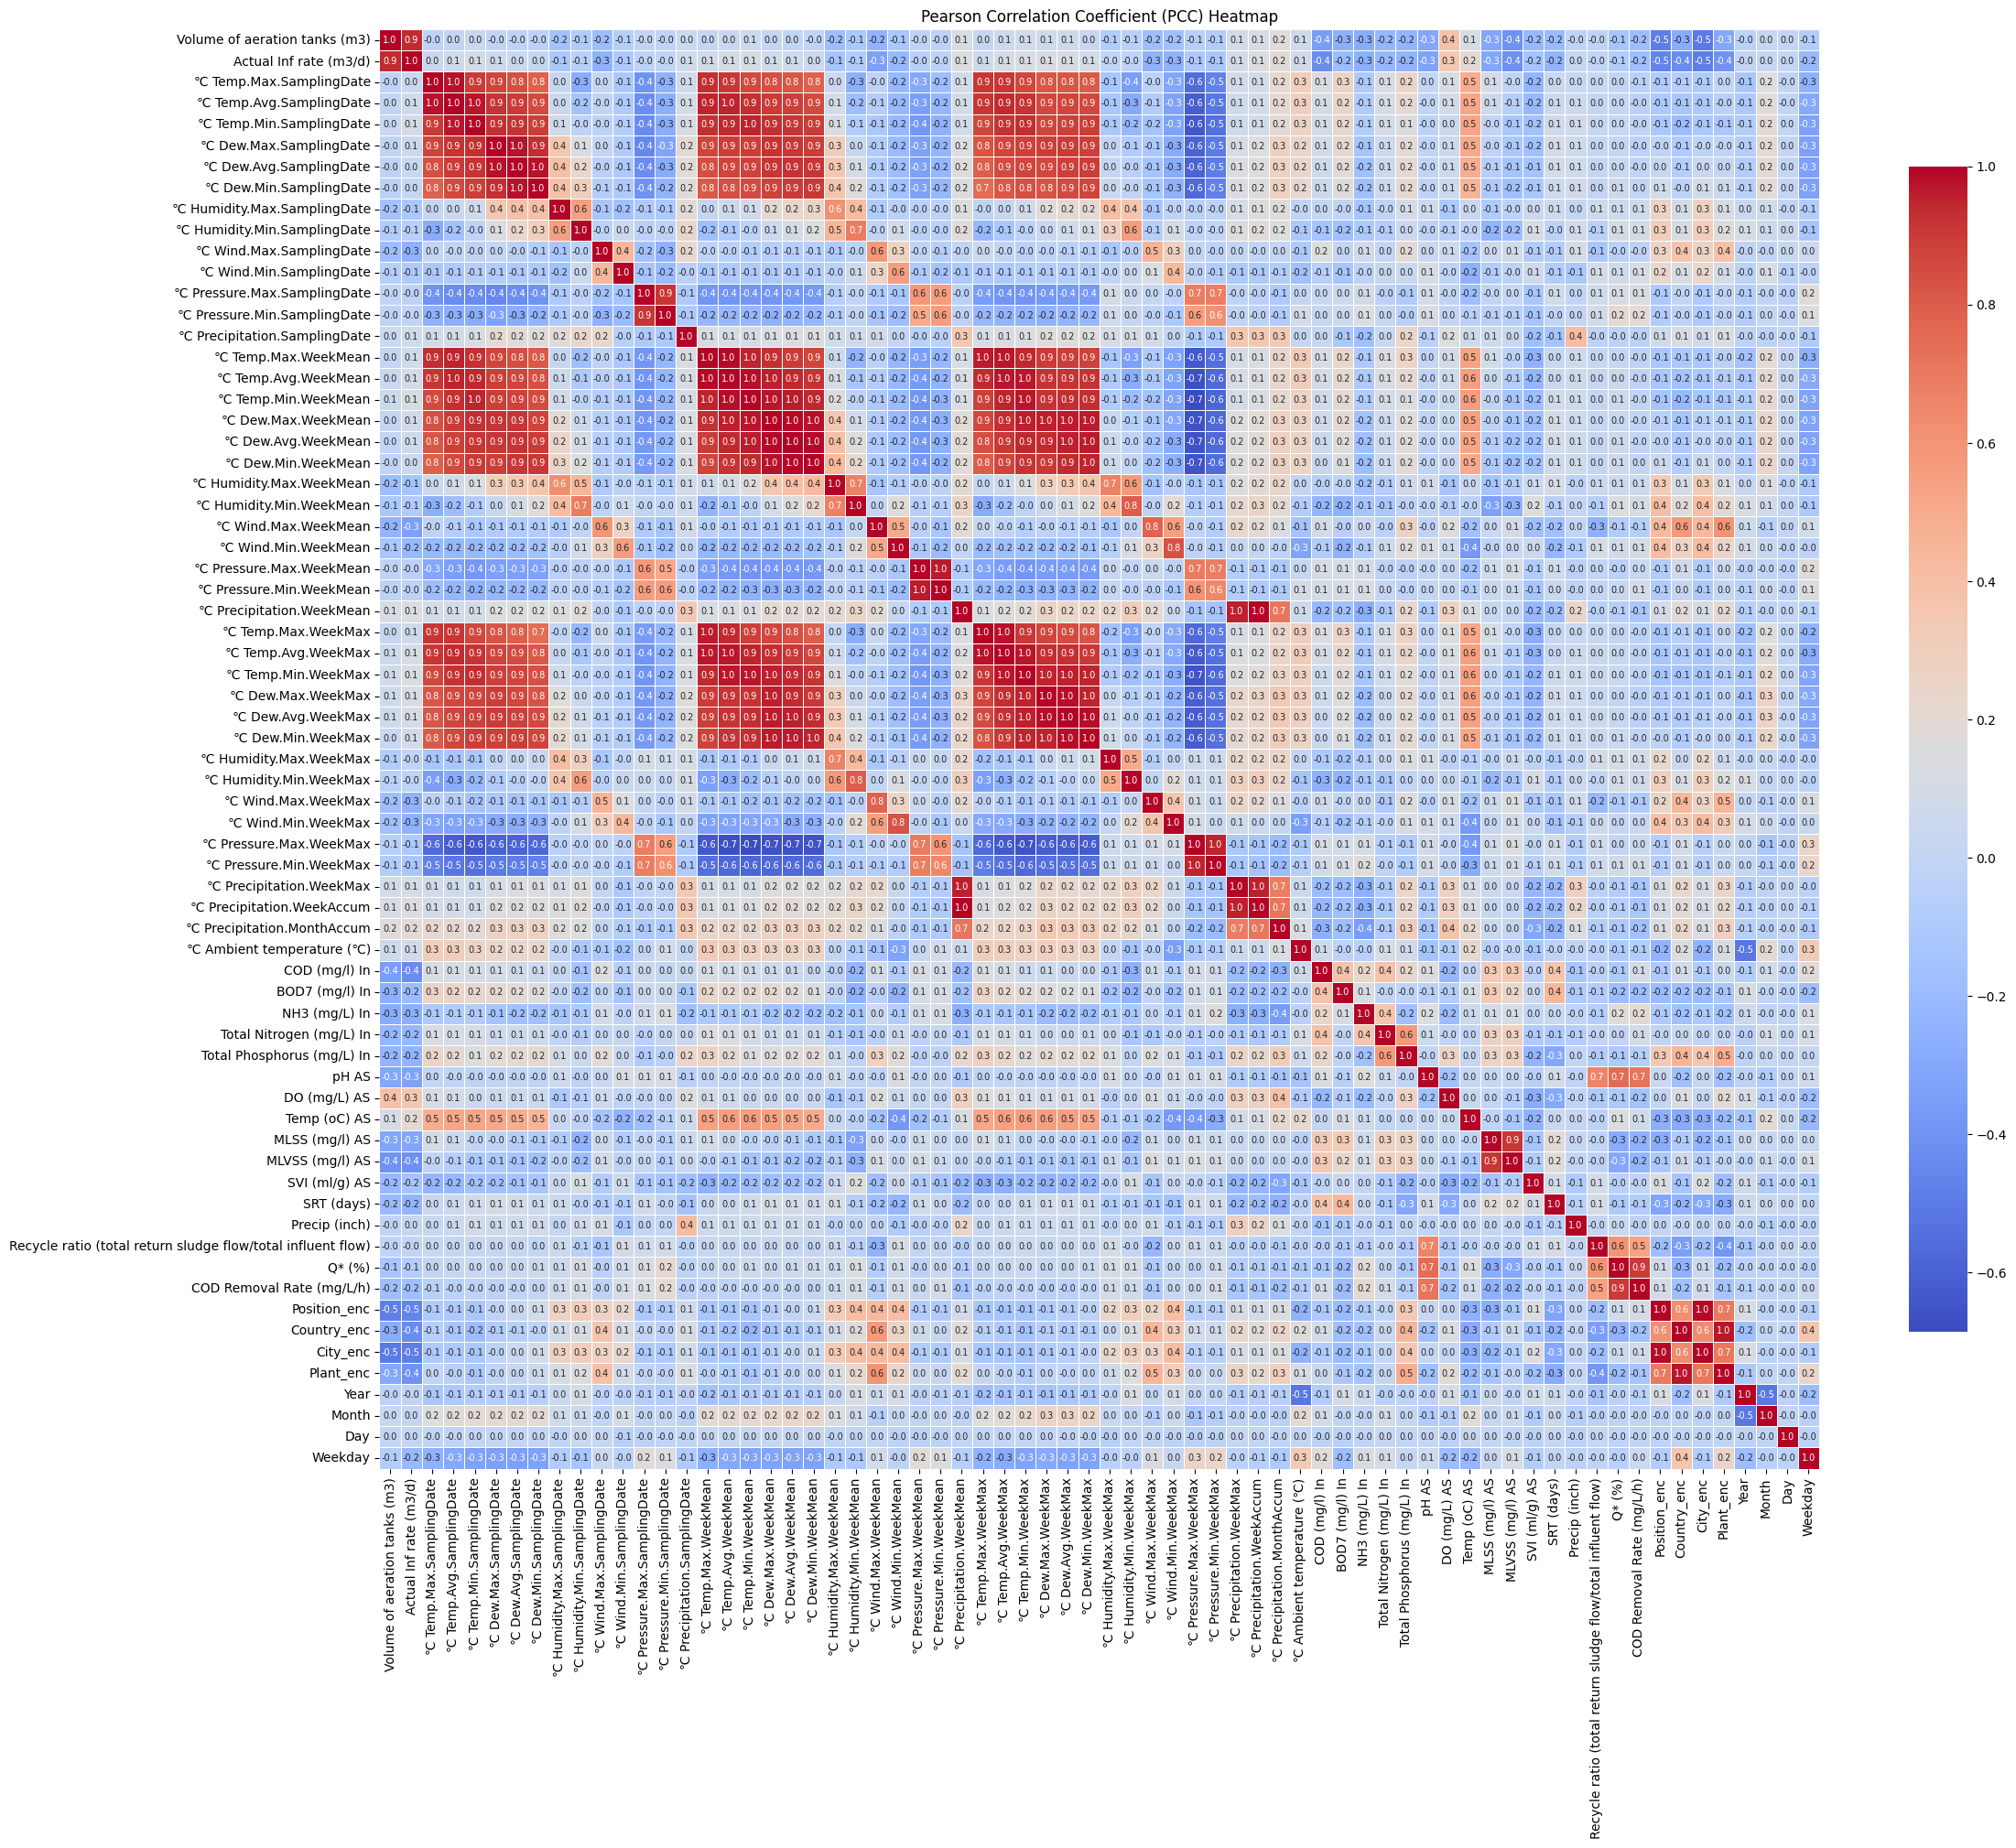

In [4]:
# 🔹 상관계수 행렬 계산 (PCC)
corr_matrix = original_df.corr(method='pearson')

# 🔹 히트맵 시각화
plt.figure(figsize=(24, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".1f", cmap='coolwarm', square=True,
            cbar_kws={"shrink": .8}, linewidths=0.5, annot_kws={"size": 7})
plt.title("Pearson Correlation Coefficient (PCC) Heatmap")
plt.tight_layout()
plt.show()

In [6]:
X = original_df[feature_columns]

y = original_df[target_column]

In [7]:
# 🔹 2. Extract feature and target columns
# Make sure 'feature_columns' and 'target_column' are predefined


# 🔹 3. Split the data into training and test sets (70:30 split with random seed 1004)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1004)

# 🔹 4. Normalize feature values using standard scaling (zero mean, unit variance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("NaNs in X_train:", np.isnan(X_train_scaled).sum())
print("NaNs in y_train:", np.isnan(y_train).sum())
print("Infs in X_train:", np.isinf(X_train_scaled).sum())
print("Infs in y_train:", np.isinf(y_train).sum())


NaNs in X_train: 0
NaNs in y_train: COD Removal Rate (mg/L/h)    0
dtype: int64
Infs in X_train: 0
Infs in y_train: COD Removal Rate (mg/L/h)    0
dtype: int64


In [8]:
# 🔹 5. Build a 3-layer deep neural network (MLP) for regression
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Output layer without activation for regression
])

# 🔹 6. Compile the model using Mean Squared Error loss and Adam optimizer
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 🔹 7. Train the model with validation on the test set
history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_test_scaled, y_test),
                    epochs=500,
                    batch_size=32,
                    verbose=1)



Epoch 1/500


/Users/k23070952/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 58248.6016 - mae: 125.8223 - val_loss: 75330.5938 - val_mae: 145.1707
Epoch 2/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 69537.4219 - mae: 128.6656 - val_loss: 62837.1055 - val_mae: 119.5631
Epoch 3/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 52031.5391 - mae: 97.3827 - val_loss: 40910.6133 - val_mae: 108.4480
Epoch 4/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 38352.4453 - mae: 100.2911 - val_loss: 22807.9141 - val_mae: 90.5612
Epoch 5/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 18711.4258 - mae: 83.3671 - val_loss: 17448.1836 - val_mae: 79.0435
Epoch 6/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 13995.9834 - mae: 66.4345 - val_loss: 15603.3564 - val_mae: 72.5767
Epoch 7/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - loss: 10662.8408 - mae: 60.3620 - val_loss: 14489.5488 - val_mae: 67.9558
Epoch 8/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 11615.0068 - mae: 57.1038 - val_loss: 13775.

In [9]:
# 🔹 8. Prediction
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


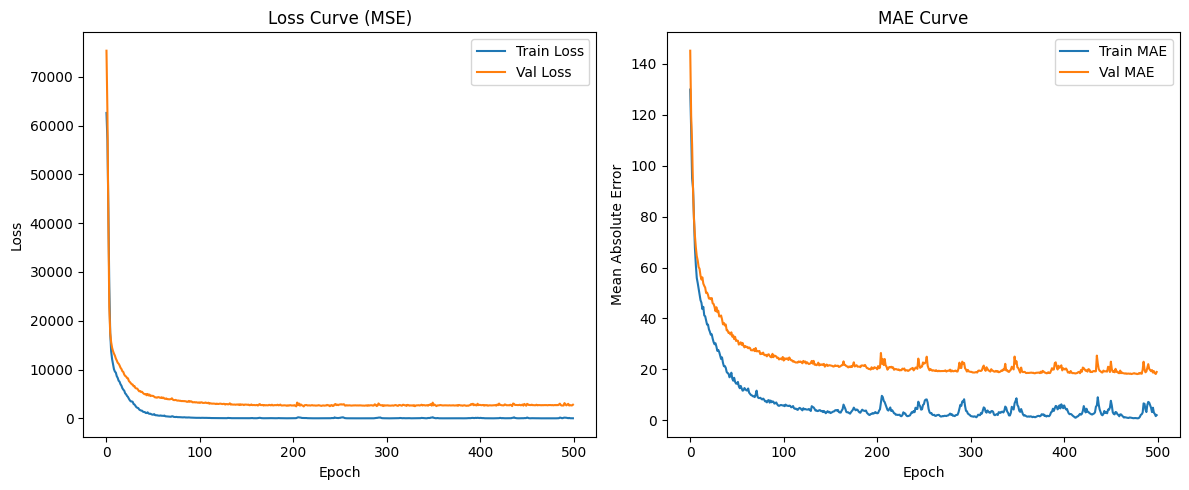

In [10]:
# 🔹 9. Plot training and validation loss/MAE over epochs
plt.figure(figsize=(12, 5))

# Plot MSE loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE Curve')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()



In [8]:
cod_corr_sorted['Recycle ratio (total return sludge flow/total influent flow)']

0.5406555204077246

In [ ]:
original_df = cod_corr_sorted.rename([]'Recycle ratio (total return sludge flow/total influent flow)', 'Recycle ratio'])

TypeError: Series.rename() takes from 1 to 2 positional arguments but 3 were given

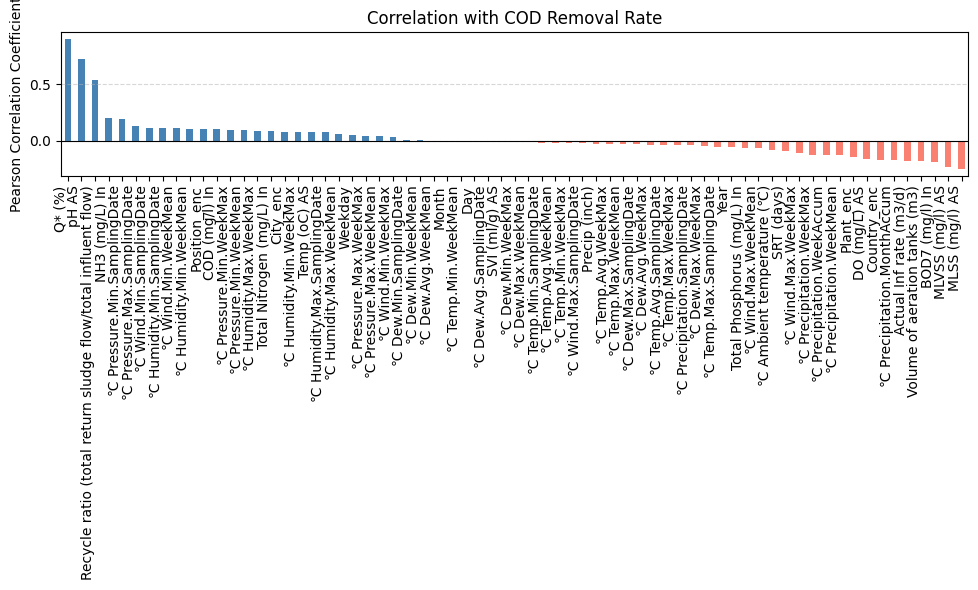

In [6]:
import matplotlib.pyplot as plt

# 1. 상관계수 행렬 계산
corr_matrix = original_df.corr(method='pearson')

# 2. COD Removal Rate과의 상관계수만 추출
cod_corr = corr_matrix["COD Removal Rate (mg/L/h)"].drop("COD Removal Rate (mg/L/h)")

# 3. 값 기준 정렬
cod_corr_sorted = cod_corr.sort_values(ascending=False)

# 4. 바 차트 시각화
plt.figure(figsize=(10, 6))
cod_corr_sorted.plot(kind='bar', color=['steelblue' if val >= 0 else 'salmon' for val in cod_corr_sorted])
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Correlation with COD Removal Rate")
plt.ylabel("Pearson Correlation Coefficient")
plt.xticks(rotation=90, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


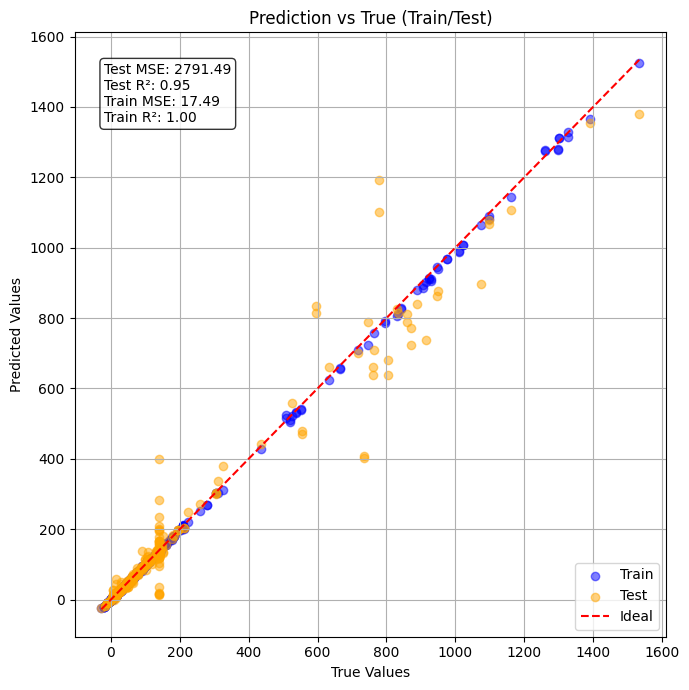

In [ ]:
plt.figure(figsize=(7, 7))

# Train set (파란색)
plt.scatter(y_train, y_train_pred, alpha=0.5, label='Train', color='blue')

# Test set (주황색)
plt.scatter(y_test, y_test_pred, alpha=0.5, label='Test', color='orange')

# Diagonal (예측 = 실제)
min_val = min(y.min().values[0], y_train_pred.min(), y_test_pred.min())
max_val = max(y.max().values[0], y_train_pred.max(), y_test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal')

# Label, title, legend
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Prediction vs True (Train/Test)")
plt.legend()
plt.grid(True)

# 🔹 성능 지표 텍스트 삽입
textstr = f"""Test MSE: {mse_test:.2f}
Test R²: {r2_test:.2f}
Train MSE: {mse_train:.2f}
Train R²: {r2_train:.2f}"""
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

## SHAP analysis

In [12]:
X_train_scaled

array([[-0.55685933, -0.62811848,  0.44426562, ...,  1.01327833,
         1.3849513 , -0.14903419],
       [-0.56425085, -0.62618821,  0.3855718 , ...,  0.42002404,
         0.35262839, -0.14903419],
       [ 1.84493901,  2.23615662,  1.09736785, ...,  0.12339689,
        -1.02380214, -1.82089205],
       ...,
       [-0.56679965, -0.62193071, -0.6815887 , ...,  0.71665118,
        -0.79439705, -0.14903419],
       [ 1.84493901,  2.23615662,  1.21582266, ...,  0.71665118,
        -0.10618178, -1.82089205],
       [-0.48840875, -0.54328509,  1.39297131, ...,  0.71665118,
         0.81143857, -0.14903419]])

In [13]:
# 샘플 일부만 사용 (SHAP은 느려서)
# 스케일링 후에도 컬럼 이름을 유지한 DataFrame으로 변환
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)

X_shap_sample = X_train_scaled_df

# 모델 예측 함수 기반으로 explainer 정의
explainer = shap.Explainer(model.predict, X_shap_sample)

# SHAP 값 계산
shap_values = explainer(X_shap_sample)



352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
392/392 ━━━

PermutationExplainer explainer:   2%|▏         | 20/875 [00:00<?, ?it/s]

372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step


PermutationExplainer explainer:   3%|▎         | 22/875 [00:10<03:26,  4.13it/s]

355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:   3%|▎         | 23/875 [00:11<04:52,  2.91it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:   3%|▎         | 24/875 [00:11<05:28,  2.59it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:   3%|▎         | 25/875 [00:12<05:50,  2.43it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step


PermutationExplainer explainer:   3%|▎         | 26/875 [00:12<06:10,  2.29it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:   3%|▎         | 27/875 [00:13<06:26,  2.19it/s]

364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:   3%|▎         | 28/875 [00:13<06:31,  2.16it/s]

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:   3%|▎         | 29/875 [00:14<06:33,  2.15it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:   3%|▎         | 30/875 [00:14<06:37,  2.13it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step


PermutationExplainer explainer:   4%|▎         | 31/875 [00:15<06:40,  2.11it/s]

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:   4%|▎         | 32/875 [00:15<06:41,  2.10it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:   4%|▍         | 33/875 [00:16<06:36,  2.12it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:   4%|▍         | 34/875 [00:16<06:31,  2.15it/s]

370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


PermutationExplainer explainer:   4%|▍         | 35/875 [00:17<06:35,  2.13it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:   4%|▍         | 36/875 [00:17<06:38,  2.11it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:   4%|▍         | 37/875 [00:18<06:33,  2.13it/s]

379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:   4%|▍         | 38/875 [00:18<06:38,  2.10it/s]

364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:   4%|▍         | 39/875 [00:19<06:34,  2.12it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step


PermutationExplainer explainer:   5%|▍         | 40/875 [00:19<06:30,  2.14it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step


PermutationExplainer explainer:   5%|▍         | 41/875 [00:20<06:36,  2.10it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:   5%|▍         | 42/875 [00:20<06:35,  2.11it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:   5%|▍         | 43/875 [00:20<06:30,  2.13it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:   5%|▌         | 44/875 [00:21<06:25,  2.15it/s]

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:   5%|▌         | 45/875 [00:21<06:27,  2.14it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


PermutationExplainer explainer:   5%|▌         | 46/875 [00:22<06:27,  2.14it/s]

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step


PermutationExplainer explainer:   5%|▌         | 47/875 [00:22<06:26,  2.14it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step


PermutationExplainer explainer:   5%|▌         | 48/875 [00:23<06:25,  2.15it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step


PermutationExplainer explainer:   6%|▌         | 49/875 [00:23<06:22,  2.16it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:   6%|▌         | 50/875 [00:24<06:22,  2.15it/s]

384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step


PermutationExplainer explainer:   6%|▌         | 51/875 [00:24<06:36,  2.08it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step


PermutationExplainer explainer:   6%|▌         | 52/875 [00:25<06:33,  2.09it/s]

364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:   6%|▌         | 53/875 [00:25<06:28,  2.12it/s]

354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:   6%|▌         | 54/875 [00:26<06:23,  2.14it/s]

370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:   6%|▋         | 55/875 [00:26<06:23,  2.14it/s]

362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:   6%|▋         | 56/875 [00:27<06:27,  2.11it/s]

381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:   7%|▋         | 57/875 [00:27<06:28,  2.11it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


PermutationExplainer explainer:   7%|▋         | 58/875 [00:27<06:23,  2.13it/s]

355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:   7%|▋         | 59/875 [00:28<06:19,  2.15it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:   7%|▋         | 60/875 [00:28<06:17,  2.16it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:   7%|▋         | 61/875 [00:29<06:22,  2.13it/s]

354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:   7%|▋         | 62/875 [00:29<06:18,  2.15it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step


PermutationExplainer explainer:   7%|▋         | 63/875 [00:30<06:19,  2.14it/s]

362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:   7%|▋         | 64/875 [00:30<06:18,  2.14it/s]

393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


PermutationExplainer explainer:   7%|▋         | 65/875 [00:31<06:27,  2.09it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:   8%|▊         | 66/875 [00:31<06:27,  2.09it/s]

352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


PermutationExplainer explainer:   8%|▊         | 67/875 [00:32<06:21,  2.12it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step


PermutationExplainer explainer:   8%|▊         | 68/875 [00:32<06:20,  2.12it/s]

364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


PermutationExplainer explainer:   8%|▊         | 69/875 [00:33<06:19,  2.12it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:   8%|▊         | 70/875 [00:33<06:20,  2.11it/s]

374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:   8%|▊         | 71/875 [00:34<06:28,  2.07it/s]

372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:   8%|▊         | 72/875 [00:34<06:24,  2.09it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step


PermutationExplainer explainer:   8%|▊         | 73/875 [00:35<06:23,  2.09it/s]

353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:   8%|▊         | 74/875 [00:35<06:17,  2.12it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


PermutationExplainer explainer:   9%|▊         | 75/875 [00:36<06:17,  2.12it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


PermutationExplainer explainer:   9%|▊         | 76/875 [00:36<06:23,  2.08it/s]

380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step


PermutationExplainer explainer:   9%|▉         | 77/875 [00:37<06:31,  2.04it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:   9%|▉         | 78/875 [00:37<06:26,  2.06it/s]

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:   9%|▉         | 79/875 [00:37<06:20,  2.09it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step


PermutationExplainer explainer:   9%|▉         | 80/875 [00:38<06:21,  2.08it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:   9%|▉         | 81/875 [00:38<06:15,  2.11it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


PermutationExplainer explainer:   9%|▉         | 82/875 [00:39<06:15,  2.11it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:   9%|▉         | 83/875 [00:39<06:15,  2.11it/s]

384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


PermutationExplainer explainer:  10%|▉         | 84/875 [00:40<06:28,  2.04it/s]

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step


PermutationExplainer explainer:  10%|▉         | 85/875 [00:40<06:32,  2.01it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  10%|▉         | 86/875 [00:41<06:26,  2.04it/s]

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step


PermutationExplainer explainer:  10%|▉         | 87/875 [00:41<06:21,  2.07it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  10%|█         | 88/875 [00:42<06:15,  2.10it/s]

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  10%|█         | 89/875 [00:42<06:15,  2.09it/s]

377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


PermutationExplainer explainer:  10%|█         | 90/875 [00:43<06:19,  2.07it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step


PermutationExplainer explainer:  10%|█         | 91/875 [00:43<06:14,  2.09it/s]

370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step


PermutationExplainer explainer:  11%|█         | 92/875 [00:44<06:12,  2.10it/s]

352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  11%|█         | 93/875 [00:44<06:07,  2.13it/s]

378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  11%|█         | 94/875 [00:45<06:11,  2.10it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  11%|█         | 95/875 [00:45<06:11,  2.10it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


PermutationExplainer explainer:  11%|█         | 96/875 [00:46<06:11,  2.10it/s]

372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  11%|█         | 97/875 [00:46<06:10,  2.10it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step


PermutationExplainer explainer:  11%|█         | 98/875 [00:47<06:09,  2.10it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step


PermutationExplainer explainer:  11%|█▏        | 99/875 [00:47<06:07,  2.11it/s]

383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step


PermutationExplainer explainer:  11%|█▏        | 100/875 [00:48<06:14,  2.07it/s]

384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  12%|█▏        | 101/875 [00:48<06:14,  2.06it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


PermutationExplainer explainer:  12%|█▏        | 102/875 [00:48<06:10,  2.08it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  12%|█▏        | 103/875 [00:49<06:08,  2.09it/s]

372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  12%|█▏        | 104/875 [00:49<06:06,  2.10it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  12%|█▏        | 105/875 [00:50<06:09,  2.08it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  12%|█▏        | 106/875 [00:50<06:04,  2.11it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  12%|█▏        | 107/875 [00:51<06:01,  2.12it/s]

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  12%|█▏        | 108/875 [00:51<06:01,  2.12it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step


PermutationExplainer explainer:  12%|█▏        | 109/875 [00:52<05:59,  2.13it/s]

377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step


PermutationExplainer explainer:  13%|█▎        | 110/875 [00:52<06:04,  2.10it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step


PermutationExplainer explainer:  13%|█▎        | 111/875 [00:53<06:03,  2.10it/s]

354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


PermutationExplainer explainer:  13%|█▎        | 112/875 [00:53<05:58,  2.13it/s]

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  13%|█▎        | 113/875 [00:54<05:58,  2.13it/s]

355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step


PermutationExplainer explainer:  13%|█▎        | 114/875 [00:54<06:20,  2.00it/s]

379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


PermutationExplainer explainer:  13%|█▎        | 115/875 [00:55<06:18,  2.01it/s]

374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  13%|█▎        | 116/875 [00:55<06:11,  2.04it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  13%|█▎        | 117/875 [00:56<06:04,  2.08it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  13%|█▎        | 118/875 [00:56<06:00,  2.10it/s]

372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step


PermutationExplainer explainer:  14%|█▎        | 119/875 [00:57<06:03,  2.08it/s]

377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step


PermutationExplainer explainer:  14%|█▎        | 120/875 [00:57<06:03,  2.08it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  14%|█▍        | 121/875 [00:58<05:58,  2.10it/s]

353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  14%|█▍        | 122/875 [00:58<05:54,  2.13it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  14%|█▍        | 123/875 [00:59<05:54,  2.12it/s]

380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  14%|█▍        | 124/875 [00:59<05:59,  2.09it/s]

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step


PermutationExplainer explainer:  14%|█▍        | 125/875 [00:59<05:57,  2.10it/s]

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step


PermutationExplainer explainer:  14%|█▍        | 126/875 [01:00<05:55,  2.11it/s]

364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


PermutationExplainer explainer:  15%|█▍        | 127/875 [01:00<05:52,  2.12it/s]

370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step


PermutationExplainer explainer:  15%|█▍        | 128/875 [01:01<05:54,  2.11it/s]

374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  15%|█▍        | 129/875 [01:01<05:57,  2.08it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  15%|█▍        | 130/875 [01:02<05:53,  2.11it/s]

354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  15%|█▍        | 131/875 [01:02<05:50,  2.12it/s]

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step


PermutationExplainer explainer:  15%|█▌        | 132/875 [01:03<05:53,  2.10it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  15%|█▌        | 133/875 [01:03<05:59,  2.07it/s]

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  15%|█▌        | 134/875 [01:04<05:56,  2.08it/s]

386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step


PermutationExplainer explainer:  15%|█▌        | 135/875 [01:04<05:59,  2.06it/s]

353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  16%|█▌        | 136/875 [01:05<05:52,  2.09it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step


PermutationExplainer explainer:  16%|█▌        | 137/875 [01:05<05:47,  2.12it/s]

350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step


PermutationExplainer explainer:  16%|█▌        | 138/875 [01:06<05:46,  2.12it/s]

382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  16%|█▌        | 139/875 [01:06<05:52,  2.09it/s]

377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  16%|█▌        | 140/875 [01:07<05:52,  2.09it/s]

354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step


PermutationExplainer explainer:  16%|█▌        | 141/875 [01:07<05:47,  2.11it/s]

385/385 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step
385/385 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
385/385 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  16%|█▌        | 142/875 [01:08<05:54,  2.07it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  16%|█▋        | 143/875 [01:08<05:53,  2.07it/s]

355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  16%|█▋        | 144/875 [01:09<05:46,  2.11it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  17%|█▋        | 145/875 [01:09<05:44,  2.12it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step


PermutationExplainer explainer:  17%|█▋        | 146/875 [01:09<05:42,  2.13it/s]

353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


PermutationExplainer explainer:  17%|█▋        | 147/875 [01:10<05:36,  2.16it/s]

364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  17%|█▋        | 148/875 [01:10<05:41,  2.13it/s]

383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  17%|█▋        | 149/875 [01:11<05:42,  2.12it/s]

364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step


PermutationExplainer explainer:  17%|█▋        | 150/875 [01:11<05:42,  2.12it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


PermutationExplainer explainer:  17%|█▋        | 151/875 [01:12<05:40,  2.13it/s]

352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step


PermutationExplainer explainer:  17%|█▋        | 152/875 [01:12<05:36,  2.15it/s]

379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step


PermutationExplainer explainer:  17%|█▋        | 153/875 [01:13<05:43,  2.10it/s]

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step


PermutationExplainer explainer:  18%|█▊        | 154/875 [01:13<05:45,  2.08it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step


PermutationExplainer explainer:  18%|█▊        | 155/875 [01:14<05:42,  2.10it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step


PermutationExplainer explainer:  18%|█▊        | 156/875 [01:14<05:41,  2.10it/s]

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step


PermutationExplainer explainer:  18%|█▊        | 157/875 [01:15<05:39,  2.12it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


PermutationExplainer explainer:  18%|█▊        | 158/875 [01:15<05:43,  2.09it/s]

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  18%|█▊        | 159/875 [01:16<05:41,  2.09it/s]

372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


PermutationExplainer explainer:  18%|█▊        | 160/875 [01:16<05:41,  2.09it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  18%|█▊        | 161/875 [01:17<05:39,  2.10it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


PermutationExplainer explainer:  19%|█▊        | 162/875 [01:17<05:41,  2.09it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  19%|█▊        | 163/875 [01:18<05:36,  2.12it/s]

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


PermutationExplainer explainer:  19%|█▊        | 164/875 [01:18<05:38,  2.10it/s]

372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step


PermutationExplainer explainer:  19%|█▉        | 165/875 [01:18<05:38,  2.10it/s]

354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  19%|█▉        | 166/875 [01:19<05:33,  2.13it/s]

378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  19%|█▉        | 167/875 [01:19<05:40,  2.08it/s]

374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step


PermutationExplainer explainer:  19%|█▉        | 168/875 [01:20<05:42,  2.06it/s]

377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  19%|█▉        | 169/875 [01:20<05:41,  2.07it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  19%|█▉        | 170/875 [01:21<05:34,  2.11it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step


PermutationExplainer explainer:  20%|█▉        | 171/875 [01:21<05:35,  2.10it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  20%|█▉        | 172/875 [01:22<05:32,  2.11it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step


PermutationExplainer explainer:  20%|█▉        | 173/875 [01:22<05:30,  2.12it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  20%|█▉        | 174/875 [01:23<05:31,  2.12it/s]

383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  20%|██        | 175/875 [01:23<05:35,  2.09it/s]

371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  20%|██        | 176/875 [01:24<05:38,  2.06it/s]

353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step


PermutationExplainer explainer:  20%|██        | 177/875 [01:24<05:33,  2.09it/s]

374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  20%|██        | 178/875 [01:25<05:33,  2.09it/s]

370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  20%|██        | 179/875 [01:25<05:31,  2.10it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


PermutationExplainer explainer:  21%|██        | 180/875 [01:26<05:30,  2.10it/s]

364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step


PermutationExplainer explainer:  21%|██        | 181/875 [01:26<05:30,  2.10it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


PermutationExplainer explainer:  21%|██        | 182/875 [01:27<05:27,  2.12it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step


PermutationExplainer explainer:  21%|██        | 183/875 [01:27<05:25,  2.13it/s]

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  21%|██        | 184/875 [01:28<05:28,  2.10it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


PermutationExplainer explainer:  21%|██        | 185/875 [01:28<05:28,  2.10it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step


PermutationExplainer explainer:  21%|██▏       | 186/875 [01:28<05:26,  2.11it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  21%|██▏       | 187/875 [01:29<05:23,  2.13it/s]

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  21%|██▏       | 188/875 [01:29<05:25,  2.11it/s]

364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


PermutationExplainer explainer:  22%|██▏       | 189/875 [01:30<05:24,  2.12it/s]

381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  22%|██▏       | 190/875 [01:30<05:28,  2.09it/s]

379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step


PermutationExplainer explainer:  22%|██▏       | 191/875 [01:31<05:30,  2.07it/s]

364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  22%|██▏       | 192/875 [01:31<05:27,  2.09it/s]

364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step


PermutationExplainer explainer:  22%|██▏       | 193/875 [01:32<05:24,  2.10it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step


PermutationExplainer explainer:  22%|██▏       | 194/875 [01:32<05:23,  2.10it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step


PermutationExplainer explainer:  22%|██▏       | 195/875 [01:33<05:20,  2.12it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step


PermutationExplainer explainer:  22%|██▏       | 196/875 [01:33<05:19,  2.13it/s]

352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  23%|██▎       | 197/875 [01:34<05:17,  2.13it/s]

352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  23%|██▎       | 198/875 [01:34<05:16,  2.14it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


PermutationExplainer explainer:  23%|██▎       | 199/875 [01:35<05:21,  2.10it/s]

353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step


PermutationExplainer explainer:  23%|██▎       | 200/875 [01:35<05:18,  2.12it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


PermutationExplainer explainer:  23%|██▎       | 201/875 [01:36<05:17,  2.12it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step


PermutationExplainer explainer:  23%|██▎       | 202/875 [01:36<05:15,  2.13it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step


PermutationExplainer explainer:  23%|██▎       | 203/875 [01:37<05:17,  2.12it/s]

377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  23%|██▎       | 204/875 [01:37<05:18,  2.11it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  23%|██▎       | 205/875 [01:37<05:17,  2.11it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


PermutationExplainer explainer:  24%|██▎       | 206/875 [01:38<05:16,  2.11it/s]

377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  24%|██▎       | 207/875 [01:38<05:18,  2.10it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  24%|██▍       | 208/875 [01:39<05:21,  2.08it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step


PermutationExplainer explainer:  24%|██▍       | 209/875 [01:39<05:19,  2.09it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step


PermutationExplainer explainer:  24%|██▍       | 210/875 [01:40<05:18,  2.09it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  24%|██▍       | 211/875 [01:40<05:16,  2.10it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  24%|██▍       | 212/875 [01:41<05:17,  2.09it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  24%|██▍       | 213/875 [01:41<05:15,  2.10it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  24%|██▍       | 214/875 [01:42<05:12,  2.11it/s]

364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


PermutationExplainer explainer:  25%|██▍       | 215/875 [01:42<05:13,  2.10it/s]

364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  25%|██▍       | 216/875 [01:43<05:11,  2.11it/s]

383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


PermutationExplainer explainer:  25%|██▍       | 217/875 [01:43<05:17,  2.07it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  25%|██▍       | 218/875 [01:44<05:15,  2.08it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  25%|██▌       | 219/875 [01:44<05:13,  2.09it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step


PermutationExplainer explainer:  25%|██▌       | 220/875 [01:45<05:13,  2.09it/s]

354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step


PermutationExplainer explainer:  25%|██▌       | 221/875 [01:45<05:10,  2.11it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step


PermutationExplainer explainer:  25%|██▌       | 222/875 [01:46<05:09,  2.11it/s]

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step


PermutationExplainer explainer:  25%|██▌       | 223/875 [01:46<05:11,  2.09it/s]

371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  26%|██▌       | 224/875 [01:47<05:10,  2.10it/s]

354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  26%|██▌       | 225/875 [01:47<05:07,  2.11it/s]

362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  26%|██▌       | 226/875 [01:48<05:10,  2.09it/s]

382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step


PermutationExplainer explainer:  26%|██▌       | 227/875 [01:48<05:12,  2.08it/s]

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


PermutationExplainer explainer:  26%|██▌       | 228/875 [01:48<05:09,  2.09it/s]

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  26%|██▌       | 229/875 [01:49<05:09,  2.09it/s]

355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


PermutationExplainer explainer:  26%|██▋       | 230/875 [01:49<05:08,  2.09it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  26%|██▋       | 231/875 [01:50<05:05,  2.11it/s]

345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step


PermutationExplainer explainer:  27%|██▋       | 232/875 [01:50<05:02,  2.12it/s]

370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  27%|██▋       | 233/875 [01:51<05:02,  2.12it/s]

353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step


PermutationExplainer explainer:  27%|██▋       | 234/875 [01:51<05:02,  2.12it/s]

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step


PermutationExplainer explainer:  27%|██▋       | 235/875 [01:52<05:04,  2.10it/s]

377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step


PermutationExplainer explainer:  27%|██▋       | 236/875 [01:52<05:05,  2.09it/s]

391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  27%|██▋       | 237/875 [01:53<05:10,  2.05it/s]

351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  27%|██▋       | 238/875 [01:53<05:07,  2.07it/s]

371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step


PermutationExplainer explainer:  27%|██▋       | 239/875 [01:54<05:07,  2.07it/s]

374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step


PermutationExplainer explainer:  27%|██▋       | 240/875 [01:54<05:07,  2.07it/s]

383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  28%|██▊       | 241/875 [01:55<05:07,  2.06it/s]

372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step


PermutationExplainer explainer:  28%|██▊       | 242/875 [01:55<05:06,  2.07it/s]

345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step


PermutationExplainer explainer:  28%|██▊       | 243/875 [01:56<05:00,  2.10it/s]

362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  28%|██▊       | 244/875 [01:56<05:01,  2.09it/s]

364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  28%|██▊       | 245/875 [01:57<05:00,  2.09it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  28%|██▊       | 246/875 [01:57<04:56,  2.12it/s]

362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step


PermutationExplainer explainer:  28%|██▊       | 247/875 [01:58<04:55,  2.12it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step


PermutationExplainer explainer:  28%|██▊       | 248/875 [01:58<04:57,  2.11it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  28%|██▊       | 249/875 [01:58<04:55,  2.12it/s]

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step


PermutationExplainer explainer:  29%|██▊       | 250/875 [01:59<04:56,  2.11it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  29%|██▊       | 251/875 [01:59<04:54,  2.12it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  29%|██▉       | 252/875 [02:00<04:53,  2.13it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  29%|██▉       | 253/875 [02:00<04:55,  2.11it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step


PermutationExplainer explainer:  29%|██▉       | 254/875 [02:01<04:55,  2.10it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step


PermutationExplainer explainer:  29%|██▉       | 255/875 [02:01<04:57,  2.09it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  29%|██▉       | 256/875 [02:02<04:53,  2.11it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


PermutationExplainer explainer:  29%|██▉       | 257/875 [02:02<04:56,  2.08it/s]

374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  29%|██▉       | 258/875 [02:03<04:56,  2.08it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step


PermutationExplainer explainer:  30%|██▉       | 259/875 [02:03<04:53,  2.10it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


PermutationExplainer explainer:  30%|██▉       | 260/875 [02:04<04:52,  2.10it/s]

370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  30%|██▉       | 261/875 [02:04<04:54,  2.09it/s]

386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  30%|██▉       | 262/875 [02:05<04:57,  2.06it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step


PermutationExplainer explainer:  30%|███       | 263/875 [02:05<04:53,  2.08it/s]

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step


PermutationExplainer explainer:  30%|███       | 264/875 [02:06<04:54,  2.07it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  30%|███       | 265/875 [02:06<04:51,  2.09it/s]

353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  30%|███       | 266/875 [02:07<04:48,  2.11it/s]

370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


PermutationExplainer explainer:  31%|███       | 267/875 [02:07<04:53,  2.07it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  31%|███       | 268/875 [02:08<04:52,  2.07it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  31%|███       | 269/875 [02:08<04:49,  2.10it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step


PermutationExplainer explainer:  31%|███       | 270/875 [02:09<04:47,  2.10it/s]

380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step


PermutationExplainer explainer:  31%|███       | 271/875 [02:09<04:45,  2.11it/s]

344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step


PermutationExplainer explainer:  31%|███       | 272/875 [02:09<04:43,  2.13it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  31%|███       | 273/875 [02:10<04:39,  2.16it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  31%|███▏      | 274/875 [02:10<04:35,  2.18it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step


PermutationExplainer explainer:  31%|███▏      | 275/875 [02:11<04:33,  2.19it/s]

372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  32%|███▏      | 276/875 [02:11<04:32,  2.19it/s]

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  32%|███▏      | 277/875 [02:12<04:36,  2.16it/s]

381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  32%|███▏      | 278/875 [02:12<04:36,  2.16it/s]

364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  32%|███▏      | 279/875 [02:13<04:34,  2.17it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  32%|███▏      | 280/875 [02:13<04:32,  2.18it/s]

362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  32%|███▏      | 281/875 [02:14<04:29,  2.20it/s]

380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  32%|███▏      | 282/875 [02:14<04:33,  2.17it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  32%|███▏      | 283/875 [02:14<04:29,  2.19it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step


PermutationExplainer explainer:  32%|███▏      | 284/875 [02:15<04:29,  2.20it/s]

354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step


PermutationExplainer explainer:  33%|███▎      | 285/875 [02:15<04:27,  2.20it/s]

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  33%|███▎      | 286/875 [02:16<04:34,  2.15it/s]

353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


PermutationExplainer explainer:  33%|███▎      | 287/875 [02:16<04:31,  2.16it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  33%|███▎      | 288/875 [02:17<04:29,  2.18it/s]

372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


PermutationExplainer explainer:  33%|███▎      | 289/875 [02:17<04:32,  2.15it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  33%|███▎      | 290/875 [02:18<04:29,  2.17it/s]

386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step


PermutationExplainer explainer:  33%|███▎      | 291/875 [02:18<04:44,  2.05it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  33%|███▎      | 292/875 [02:19<04:41,  2.07it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  33%|███▎      | 293/875 [02:19<04:35,  2.11it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  34%|███▎      | 294/875 [02:20<04:31,  2.14it/s]

353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  34%|███▎      | 295/875 [02:20<04:26,  2.17it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


PermutationExplainer explainer:  34%|███▍      | 296/875 [02:21<04:28,  2.15it/s]

362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step


PermutationExplainer explainer:  34%|███▍      | 297/875 [02:21<04:25,  2.18it/s]

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  34%|███▍      | 298/875 [02:21<04:23,  2.19it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  34%|███▍      | 299/875 [02:22<04:20,  2.21it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


PermutationExplainer explainer:  34%|███▍      | 300/875 [02:22<04:20,  2.21it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  34%|███▍      | 301/875 [02:23<04:22,  2.19it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  35%|███▍      | 302/875 [02:23<04:19,  2.21it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  35%|███▍      | 303/875 [02:24<04:19,  2.20it/s]

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  35%|███▍      | 304/875 [02:24<04:19,  2.20it/s]

355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  35%|███▍      | 305/875 [02:25<04:17,  2.21it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  35%|███▍      | 306/875 [02:25<04:20,  2.19it/s]

355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step


PermutationExplainer explainer:  35%|███▌      | 307/875 [02:26<04:20,  2.18it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


PermutationExplainer explainer:  35%|███▌      | 308/875 [02:26<04:24,  2.14it/s]

382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


PermutationExplainer explainer:  35%|███▌      | 309/875 [02:27<04:29,  2.10it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  35%|███▌      | 310/875 [02:27<04:27,  2.11it/s]

355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  36%|███▌      | 311/875 [02:27<04:22,  2.15it/s]

364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  36%|███▌      | 312/875 [02:28<04:21,  2.15it/s]

353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  36%|███▌      | 313/875 [02:28<04:17,  2.18it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


PermutationExplainer explainer:  36%|███▌      | 314/875 [02:29<04:16,  2.19it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  36%|███▌      | 315/875 [02:29<04:18,  2.17it/s]

379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step


PermutationExplainer explainer:  36%|███▌      | 316/875 [02:30<04:35,  2.03it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  36%|███▌      | 317/875 [02:30<04:28,  2.08it/s]

371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  36%|███▋      | 318/875 [02:31<04:24,  2.11it/s]

374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


PermutationExplainer explainer:  36%|███▋      | 319/875 [02:31<04:22,  2.12it/s]

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  37%|███▋      | 320/875 [02:32<04:21,  2.12it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  37%|███▋      | 321/875 [02:32<04:18,  2.14it/s]

385/385 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
385/385 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
385/385 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step


PermutationExplainer explainer:  37%|███▋      | 322/875 [02:33<04:19,  2.13it/s]

362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step


PermutationExplainer explainer:  37%|███▋      | 323/875 [02:33<04:17,  2.15it/s]

377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  37%|███▋      | 324/875 [02:34<04:15,  2.15it/s]

379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step


PermutationExplainer explainer:  37%|███▋      | 325/875 [02:34<04:17,  2.13it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  37%|███▋      | 326/875 [02:34<04:13,  2.16it/s]

371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  37%|███▋      | 327/875 [02:35<04:13,  2.16it/s]

390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step


PermutationExplainer explainer:  37%|███▋      | 328/875 [02:35<04:16,  2.13it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  38%|███▊      | 329/875 [02:36<04:12,  2.16it/s]

384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  38%|███▊      | 330/875 [02:36<04:15,  2.13it/s]

382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step


PermutationExplainer explainer:  38%|███▊      | 331/875 [02:37<04:14,  2.14it/s]

364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  38%|███▊      | 332/875 [02:37<04:11,  2.16it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step


PermutationExplainer explainer:  38%|███▊      | 333/875 [02:38<04:09,  2.17it/s]

352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step


PermutationExplainer explainer:  38%|███▊      | 334/875 [02:38<04:07,  2.19it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  38%|███▊      | 335/875 [02:39<04:10,  2.16it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  38%|███▊      | 336/875 [02:39<04:09,  2.16it/s]

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  39%|███▊      | 337/875 [02:40<04:09,  2.16it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step


PermutationExplainer explainer:  39%|███▊      | 338/875 [02:40<04:09,  2.16it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step


PermutationExplainer explainer:  39%|███▊      | 339/875 [02:40<04:08,  2.16it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step


PermutationExplainer explainer:  39%|███▉      | 340/875 [02:41<04:07,  2.16it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  39%|███▉      | 341/875 [02:41<04:06,  2.16it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  39%|███▉      | 342/875 [02:42<04:03,  2.18it/s]

344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  39%|███▉      | 343/875 [02:42<04:00,  2.21it/s]

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  39%|███▉      | 344/875 [02:43<04:03,  2.18it/s]

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  39%|███▉      | 345/875 [02:43<04:04,  2.17it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step


PermutationExplainer explainer:  40%|███▉      | 346/875 [02:44<04:02,  2.18it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step


PermutationExplainer explainer:  40%|███▉      | 347/875 [02:44<04:00,  2.19it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step


PermutationExplainer explainer:  40%|███▉      | 348/875 [02:45<04:00,  2.19it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step


PermutationExplainer explainer:  40%|███▉      | 349/875 [02:45<04:03,  2.16it/s]

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  40%|████      | 350/875 [02:46<04:03,  2.16it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  40%|████      | 351/875 [02:46<04:00,  2.18it/s]

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step


PermutationExplainer explainer:  40%|████      | 352/875 [02:46<03:59,  2.18it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


PermutationExplainer explainer:  40%|████      | 353/875 [02:47<04:03,  2.15it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step


PermutationExplainer explainer:  40%|████      | 354/875 [02:47<04:02,  2.15it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  41%|████      | 355/875 [02:48<04:05,  2.12it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  41%|████      | 356/875 [02:48<04:01,  2.15it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step


PermutationExplainer explainer:  41%|████      | 357/875 [02:49<04:00,  2.15it/s]

386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step


PermutationExplainer explainer:  41%|████      | 358/875 [02:49<04:11,  2.06it/s]

374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step


PermutationExplainer explainer:  41%|████      | 359/875 [02:50<04:11,  2.05it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step


PermutationExplainer explainer:  41%|████      | 360/875 [02:50<04:09,  2.07it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step


PermutationExplainer explainer:  41%|████▏     | 361/875 [02:51<04:12,  2.04it/s]

371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step


PermutationExplainer explainer:  41%|████▏     | 362/875 [02:51<04:09,  2.05it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  41%|████▏     | 363/875 [02:52<04:05,  2.08it/s]

353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step


PermutationExplainer explainer:  42%|████▏     | 364/875 [02:52<04:04,  2.09it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


PermutationExplainer explainer:  42%|████▏     | 365/875 [02:53<04:06,  2.07it/s]

381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


PermutationExplainer explainer:  42%|████▏     | 366/875 [02:53<04:07,  2.06it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  42%|████▏     | 367/875 [02:54<04:04,  2.08it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  42%|████▏     | 368/875 [02:54<04:03,  2.08it/s]

385/385 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
385/385 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
385/385 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step


PermutationExplainer explainer:  42%|████▏     | 369/875 [02:55<04:04,  2.07it/s]

374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


PermutationExplainer explainer:  42%|████▏     | 370/875 [02:55<04:06,  2.05it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  42%|████▏     | 371/875 [02:56<04:05,  2.06it/s]

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step


PermutationExplainer explainer:  43%|████▎     | 372/875 [02:56<04:04,  2.06it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  43%|████▎     | 373/875 [02:57<04:02,  2.07it/s]

345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  43%|████▎     | 374/875 [02:57<03:59,  2.09it/s]

377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step


PermutationExplainer explainer:  43%|████▎     | 375/875 [02:58<03:58,  2.09it/s]

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step


PermutationExplainer explainer:  43%|████▎     | 376/875 [02:58<03:56,  2.11it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  43%|████▎     | 377/875 [02:58<03:53,  2.13it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


PermutationExplainer explainer:  43%|████▎     | 378/875 [02:59<03:50,  2.16it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  43%|████▎     | 379/875 [02:59<03:51,  2.14it/s]

364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  43%|████▎     | 380/875 [03:00<03:49,  2.16it/s]

372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  44%|████▎     | 381/875 [03:00<03:49,  2.16it/s]

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  44%|████▎     | 382/875 [03:01<03:48,  2.16it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step


PermutationExplainer explainer:  44%|████▍     | 383/875 [03:01<03:47,  2.16it/s]

387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step


PermutationExplainer explainer:  44%|████▍     | 384/875 [03:02<03:52,  2.11it/s]

362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


PermutationExplainer explainer:  44%|████▍     | 385/875 [03:02<03:48,  2.14it/s]

372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  44%|████▍     | 386/875 [03:03<03:47,  2.15it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  44%|████▍     | 387/875 [03:03<03:44,  2.17it/s]

370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step


PermutationExplainer explainer:  44%|████▍     | 388/875 [03:04<03:44,  2.17it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  44%|████▍     | 389/875 [03:04<03:45,  2.16it/s]

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step


PermutationExplainer explainer:  45%|████▍     | 390/875 [03:04<03:45,  2.15it/s]

362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


PermutationExplainer explainer:  45%|████▍     | 391/875 [03:05<03:44,  2.16it/s]

355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  45%|████▍     | 392/875 [03:05<03:42,  2.17it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step


PermutationExplainer explainer:  45%|████▍     | 393/875 [03:06<03:41,  2.17it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  45%|████▌     | 394/875 [03:06<03:42,  2.17it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  45%|████▌     | 395/875 [03:07<03:39,  2.19it/s]

374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  45%|████▌     | 396/875 [03:07<03:39,  2.18it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step


PermutationExplainer explainer:  45%|████▌     | 397/875 [03:08<03:38,  2.19it/s]

364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  45%|████▌     | 398/875 [03:08<03:37,  2.19it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step


PermutationExplainer explainer:  46%|████▌     | 399/875 [03:09<03:38,  2.18it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  46%|████▌     | 400/875 [03:09<03:39,  2.16it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step


PermutationExplainer explainer:  46%|████▌     | 401/875 [03:10<03:39,  2.16it/s]

385/385 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
385/385 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
385/385 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  46%|████▌     | 402/875 [03:10<03:41,  2.14it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


PermutationExplainer explainer:  46%|████▌     | 403/875 [03:10<03:38,  2.16it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  46%|████▌     | 404/875 [03:11<03:39,  2.14it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  46%|████▋     | 405/875 [03:11<03:39,  2.15it/s]

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  46%|████▋     | 406/875 [03:12<03:37,  2.16it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  47%|████▋     | 407/875 [03:12<03:37,  2.15it/s]

355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  47%|████▋     | 408/875 [03:13<03:33,  2.19it/s]

362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  47%|████▋     | 409/875 [03:13<03:33,  2.18it/s]

384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  47%|████▋     | 410/875 [03:14<03:35,  2.15it/s]

384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  47%|████▋     | 411/875 [03:14<03:37,  2.13it/s]

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  47%|████▋     | 412/875 [03:15<03:36,  2.13it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  47%|████▋     | 413/875 [03:15<03:33,  2.16it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  47%|████▋     | 414/875 [03:16<03:36,  2.12it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


PermutationExplainer explainer:  47%|████▋     | 415/875 [03:16<03:35,  2.13it/s]

379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step


PermutationExplainer explainer:  48%|████▊     | 416/875 [03:17<03:36,  2.12it/s]

382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  48%|████▊     | 417/875 [03:17<03:36,  2.12it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  48%|████▊     | 418/875 [03:17<03:34,  2.13it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  48%|████▊     | 419/875 [03:18<03:32,  2.15it/s]

362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step


PermutationExplainer explainer:  48%|████▊     | 420/875 [03:18<03:30,  2.17it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  48%|████▊     | 421/875 [03:19<03:30,  2.16it/s]

378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  48%|████▊     | 422/875 [03:19<03:29,  2.16it/s]

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


PermutationExplainer explainer:  48%|████▊     | 423/875 [03:20<03:30,  2.15it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  48%|████▊     | 424/875 [03:20<03:29,  2.16it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  49%|████▊     | 425/875 [03:21<03:26,  2.18it/s]

374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step


PermutationExplainer explainer:  49%|████▊     | 426/875 [03:21<03:26,  2.17it/s]

350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


PermutationExplainer explainer:  49%|████▉     | 427/875 [03:22<03:24,  2.20it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  49%|████▉     | 428/875 [03:22<03:25,  2.18it/s]

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  49%|████▉     | 429/875 [03:23<03:26,  2.16it/s]

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step


PermutationExplainer explainer:  49%|████▉     | 430/875 [03:23<03:26,  2.15it/s]

377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  49%|████▉     | 431/875 [03:23<03:26,  2.15it/s]

372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step


PermutationExplainer explainer:  49%|████▉     | 432/875 [03:24<03:26,  2.15it/s]

385/385 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
385/385 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
385/385 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  49%|████▉     | 433/875 [03:24<03:27,  2.13it/s]

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  50%|████▉     | 434/875 [03:25<03:28,  2.12it/s]

351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  50%|████▉     | 435/875 [03:25<03:23,  2.16it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step


PermutationExplainer explainer:  50%|████▉     | 436/875 [03:26<03:22,  2.17it/s]

362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  50%|████▉     | 437/875 [03:26<03:23,  2.15it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step


PermutationExplainer explainer:  50%|█████     | 438/875 [03:27<03:21,  2.17it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step


PermutationExplainer explainer:  50%|█████     | 439/875 [03:27<03:22,  2.16it/s]

362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  50%|█████     | 440/875 [03:28<03:20,  2.17it/s]

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


PermutationExplainer explainer:  50%|█████     | 441/875 [03:28<03:20,  2.17it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  51%|█████     | 442/875 [03:29<03:19,  2.17it/s]

370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  51%|█████     | 443/875 [03:29<03:19,  2.17it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  51%|█████     | 444/875 [03:30<03:20,  2.15it/s]

389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  51%|█████     | 445/875 [03:30<03:23,  2.12it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  51%|█████     | 446/875 [03:30<03:22,  2.12it/s]

362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  51%|█████     | 447/875 [03:31<03:19,  2.14it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step


PermutationExplainer explainer:  51%|█████     | 448/875 [03:31<03:17,  2.17it/s]

355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  51%|█████▏    | 449/875 [03:32<03:16,  2.16it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


PermutationExplainer explainer:  51%|█████▏    | 450/875 [03:32<03:14,  2.19it/s]

378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  52%|█████▏    | 451/875 [03:33<03:15,  2.17it/s]

385/385 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
385/385 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
385/385 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  52%|█████▏    | 452/875 [03:33<03:15,  2.17it/s]

371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  52%|█████▏    | 453/875 [03:34<03:14,  2.17it/s]

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  52%|█████▏    | 454/875 [03:34<03:15,  2.15it/s]

380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  52%|█████▏    | 455/875 [03:35<03:15,  2.15it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  52%|█████▏    | 456/875 [03:35<03:13,  2.17it/s]

379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step


PermutationExplainer explainer:  52%|█████▏    | 457/875 [03:36<03:12,  2.17it/s]

374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step


PermutationExplainer explainer:  52%|█████▏    | 458/875 [03:36<03:12,  2.16it/s]

362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  52%|█████▏    | 459/875 [03:36<03:12,  2.16it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step


PermutationExplainer explainer:  53%|█████▎    | 460/875 [03:37<03:11,  2.16it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  53%|█████▎    | 461/875 [03:37<03:10,  2.18it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  53%|█████▎    | 462/875 [03:38<03:09,  2.18it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  53%|█████▎    | 463/875 [03:38<03:08,  2.19it/s]

374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  53%|█████▎    | 464/875 [03:39<03:10,  2.16it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step


PermutationExplainer explainer:  53%|█████▎    | 465/875 [03:39<03:08,  2.17it/s]

364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  53%|█████▎    | 466/875 [03:40<03:07,  2.18it/s]

371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  53%|█████▎    | 467/875 [03:40<03:06,  2.19it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  53%|█████▎    | 468/875 [03:41<03:06,  2.18it/s]

372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step


PermutationExplainer explainer:  54%|█████▎    | 469/875 [03:41<03:07,  2.16it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


PermutationExplainer explainer:  54%|█████▎    | 470/875 [03:41<03:05,  2.18it/s]

364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step


PermutationExplainer explainer:  54%|█████▍    | 471/875 [03:42<03:03,  2.20it/s]

380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


PermutationExplainer explainer:  54%|█████▍    | 472/875 [03:42<03:04,  2.18it/s]

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step


PermutationExplainer explainer:  54%|█████▍    | 473/875 [03:43<03:03,  2.20it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  54%|█████▍    | 474/875 [03:43<03:03,  2.18it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  54%|█████▍    | 475/875 [03:44<03:02,  2.19it/s]

371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  54%|█████▍    | 476/875 [03:44<03:04,  2.17it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  55%|█████▍    | 477/875 [03:45<03:03,  2.17it/s]

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  55%|█████▍    | 478/875 [03:45<03:02,  2.17it/s]

370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  55%|█████▍    | 479/875 [03:46<03:03,  2.16it/s]

380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


PermutationExplainer explainer:  55%|█████▍    | 480/875 [03:46<03:03,  2.15it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  55%|█████▍    | 481/875 [03:47<03:01,  2.17it/s]

372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  55%|█████▌    | 482/875 [03:47<03:01,  2.17it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


PermutationExplainer explainer:  55%|█████▌    | 483/875 [03:47<03:00,  2.18it/s]

355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  55%|█████▌    | 484/875 [03:48<02:59,  2.18it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step


PermutationExplainer explainer:  55%|█████▌    | 485/875 [03:48<02:59,  2.17it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  56%|█████▌    | 486/875 [03:49<02:58,  2.18it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  56%|█████▌    | 487/875 [03:49<02:57,  2.18it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  56%|█████▌    | 488/875 [03:50<02:56,  2.19it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step


PermutationExplainer explainer:  56%|█████▌    | 489/875 [03:50<02:58,  2.17it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  56%|█████▌    | 490/875 [03:51<02:56,  2.18it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  56%|█████▌    | 491/875 [03:51<02:55,  2.19it/s]

364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  56%|█████▌    | 492/875 [03:52<02:55,  2.18it/s]

362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  56%|█████▋    | 493/875 [03:52<02:54,  2.19it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  56%|█████▋    | 494/875 [03:53<02:54,  2.18it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  57%|█████▋    | 495/875 [03:53<02:52,  2.21it/s]

354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step


PermutationExplainer explainer:  57%|█████▋    | 496/875 [03:53<02:50,  2.23it/s]

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  57%|█████▋    | 497/875 [03:54<02:49,  2.23it/s]

371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step


PermutationExplainer explainer:  57%|█████▋    | 498/875 [03:54<02:49,  2.22it/s]

374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  57%|█████▋    | 499/875 [03:55<02:52,  2.19it/s]

378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step


PermutationExplainer explainer:  57%|█████▋    | 500/875 [03:55<02:52,  2.17it/s]

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  57%|█████▋    | 501/875 [03:56<02:52,  2.17it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  57%|█████▋    | 502/875 [03:56<02:50,  2.18it/s]

378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  57%|█████▋    | 503/875 [03:57<02:51,  2.17it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  58%|█████▊    | 504/875 [03:57<02:52,  2.15it/s]

382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  58%|█████▊    | 505/875 [03:58<02:52,  2.15it/s]

374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  58%|█████▊    | 506/875 [03:58<02:51,  2.15it/s]

383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  58%|█████▊    | 507/875 [03:58<02:51,  2.15it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  58%|█████▊    | 508/875 [03:59<02:50,  2.16it/s]

389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  58%|█████▊    | 509/875 [03:59<02:52,  2.12it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  58%|█████▊    | 510/875 [04:00<02:50,  2.15it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  58%|█████▊    | 511/875 [04:00<02:49,  2.15it/s]

354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  59%|█████▊    | 512/875 [04:01<02:45,  2.19it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  59%|█████▊    | 513/875 [04:01<02:45,  2.19it/s]

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step


PermutationExplainer explainer:  59%|█████▊    | 514/875 [04:02<02:45,  2.18it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step


PermutationExplainer explainer:  59%|█████▉    | 515/875 [04:02<02:43,  2.20it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step


PermutationExplainer explainer:  59%|█████▉    | 516/875 [04:03<02:42,  2.21it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  59%|█████▉    | 517/875 [04:03<02:41,  2.21it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  59%|█████▉    | 518/875 [04:04<02:42,  2.20it/s]

374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step


PermutationExplainer explainer:  59%|█████▉    | 519/875 [04:04<02:42,  2.19it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step


PermutationExplainer explainer:  59%|█████▉    | 520/875 [04:04<02:41,  2.20it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  60%|█████▉    | 521/875 [04:05<02:40,  2.21it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  60%|█████▉    | 522/875 [04:05<02:51,  2.06it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step


PermutationExplainer explainer:  60%|█████▉    | 523/875 [04:06<02:47,  2.10it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  60%|█████▉    | 524/875 [04:06<02:44,  2.13it/s]

374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  60%|██████    | 525/875 [04:07<02:43,  2.14it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


PermutationExplainer explainer:  60%|██████    | 526/875 [04:07<02:42,  2.15it/s]

383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  60%|██████    | 527/875 [04:08<02:43,  2.13it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step


PermutationExplainer explainer:  60%|██████    | 528/875 [04:08<02:41,  2.14it/s]

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


PermutationExplainer explainer:  60%|██████    | 529/875 [04:09<02:40,  2.15it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  61%|██████    | 530/875 [04:09<02:38,  2.17it/s]

386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step


PermutationExplainer explainer:  61%|██████    | 531/875 [04:10<02:39,  2.15it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step


PermutationExplainer explainer:  61%|██████    | 532/875 [04:10<02:40,  2.13it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step


PermutationExplainer explainer:  61%|██████    | 533/875 [04:11<02:38,  2.16it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  61%|██████    | 534/875 [04:11<02:37,  2.17it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  61%|██████    | 535/875 [04:11<02:35,  2.18it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  61%|██████▏   | 536/875 [04:12<02:35,  2.18it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  61%|██████▏   | 537/875 [04:12<02:36,  2.16it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  61%|██████▏   | 538/875 [04:13<02:36,  2.15it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step


PermutationExplainer explainer:  62%|██████▏   | 539/875 [04:13<02:36,  2.15it/s]

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  62%|██████▏   | 540/875 [04:14<02:34,  2.17it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step


PermutationExplainer explainer:  62%|██████▏   | 541/875 [04:14<02:34,  2.16it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  62%|██████▏   | 542/875 [04:15<02:33,  2.17it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step


PermutationExplainer explainer:  62%|██████▏   | 543/875 [04:15<02:32,  2.18it/s]

393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step


PermutationExplainer explainer:  62%|██████▏   | 544/875 [04:16<02:33,  2.16it/s]

377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  62%|██████▏   | 545/875 [04:16<02:33,  2.15it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step


PermutationExplainer explainer:  62%|██████▏   | 546/875 [04:17<02:32,  2.16it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  63%|██████▎   | 547/875 [04:17<02:29,  2.20it/s]

364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  63%|██████▎   | 548/875 [04:17<02:28,  2.20it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  63%|██████▎   | 549/875 [04:18<02:27,  2.21it/s]

354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  63%|██████▎   | 550/875 [04:18<02:25,  2.23it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  63%|██████▎   | 551/875 [04:19<02:27,  2.19it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  63%|██████▎   | 552/875 [04:19<02:26,  2.20it/s]

377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step


PermutationExplainer explainer:  63%|██████▎   | 553/875 [04:20<02:28,  2.17it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  63%|██████▎   | 554/875 [04:20<02:27,  2.18it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  63%|██████▎   | 555/875 [04:21<02:26,  2.19it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  64%|██████▎   | 556/875 [04:21<02:27,  2.17it/s]

370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  64%|██████▎   | 557/875 [04:22<02:27,  2.15it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  64%|██████▍   | 558/875 [04:22<02:27,  2.15it/s]

352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  64%|██████▍   | 559/875 [04:22<02:25,  2.17it/s]

387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  64%|██████▍   | 560/875 [04:23<02:27,  2.14it/s]

392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  64%|██████▍   | 561/875 [04:23<02:29,  2.11it/s]

355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


PermutationExplainer explainer:  64%|██████▍   | 562/875 [04:24<02:26,  2.14it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  64%|██████▍   | 563/875 [04:24<02:26,  2.13it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step


PermutationExplainer explainer:  64%|██████▍   | 564/875 [04:25<02:23,  2.16it/s]

352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step


PermutationExplainer explainer:  65%|██████▍   | 565/875 [04:25<02:22,  2.18it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  65%|██████▍   | 566/875 [04:26<02:23,  2.16it/s]

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  65%|██████▍   | 567/875 [04:26<02:23,  2.15it/s]

355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step


PermutationExplainer explainer:  65%|██████▍   | 568/875 [04:27<02:21,  2.17it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  65%|██████▌   | 569/875 [04:27<02:19,  2.19it/s]

352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  65%|██████▌   | 570/875 [04:28<02:20,  2.18it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  65%|██████▌   | 571/875 [04:28<02:19,  2.19it/s]

371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  65%|██████▌   | 572/875 [04:28<02:19,  2.17it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  65%|██████▌   | 573/875 [04:29<02:19,  2.17it/s]

374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  66%|██████▌   | 574/875 [04:29<02:18,  2.17it/s]

352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  66%|██████▌   | 575/875 [04:30<02:17,  2.18it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  66%|██████▌   | 576/875 [04:30<02:16,  2.19it/s]

374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  66%|██████▌   | 577/875 [04:31<02:17,  2.16it/s]

372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  66%|██████▌   | 578/875 [04:31<02:17,  2.16it/s]

383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  66%|██████▌   | 579/875 [04:32<02:17,  2.14it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


PermutationExplainer explainer:  66%|██████▋   | 580/875 [04:32<02:17,  2.14it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step


PermutationExplainer explainer:  66%|██████▋   | 581/875 [04:33<02:16,  2.16it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  67%|██████▋   | 582/875 [04:33<02:15,  2.16it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  67%|██████▋   | 583/875 [04:34<02:14,  2.17it/s]

384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step


PermutationExplainer explainer:  67%|██████▋   | 584/875 [04:34<02:15,  2.15it/s]

384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  67%|██████▋   | 585/875 [04:35<02:16,  2.12it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  67%|██████▋   | 586/875 [04:35<02:15,  2.13it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step


PermutationExplainer explainer:  67%|██████▋   | 587/875 [04:35<02:14,  2.13it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  67%|██████▋   | 588/875 [04:36<02:13,  2.15it/s]

371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  67%|██████▋   | 589/875 [04:36<02:14,  2.13it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step


PermutationExplainer explainer:  67%|██████▋   | 590/875 [04:37<02:12,  2.15it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  68%|██████▊   | 591/875 [04:37<02:11,  2.16it/s]

377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  68%|██████▊   | 592/875 [04:38<02:11,  2.15it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  68%|██████▊   | 593/875 [04:38<02:10,  2.15it/s]

353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  68%|██████▊   | 594/875 [04:39<02:10,  2.16it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  68%|██████▊   | 595/875 [04:39<02:10,  2.15it/s]

377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


PermutationExplainer explainer:  68%|██████▊   | 596/875 [04:40<02:10,  2.14it/s]

374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  68%|██████▊   | 597/875 [04:40<02:09,  2.15it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  68%|██████▊   | 598/875 [04:41<02:09,  2.14it/s]

352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  68%|██████▊   | 599/875 [04:41<02:06,  2.18it/s]

381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step


PermutationExplainer explainer:  69%|██████▊   | 600/875 [04:42<02:07,  2.16it/s]

374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  69%|██████▊   | 601/875 [04:42<02:07,  2.15it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


PermutationExplainer explainer:  69%|██████▉   | 602/875 [04:42<02:06,  2.16it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


PermutationExplainer explainer:  69%|██████▉   | 603/875 [04:43<02:05,  2.16it/s]

355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  69%|██████▉   | 604/875 [04:43<02:04,  2.18it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  69%|██████▉   | 605/875 [04:44<02:03,  2.19it/s]

354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  69%|██████▉   | 606/875 [04:44<02:02,  2.19it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  69%|██████▉   | 607/875 [04:45<02:03,  2.17it/s]

394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  69%|██████▉   | 608/875 [04:45<02:06,  2.12it/s]

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step


PermutationExplainer explainer:  70%|██████▉   | 609/875 [04:46<02:06,  2.10it/s]

370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  70%|██████▉   | 610/875 [04:46<02:06,  2.10it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  70%|██████▉   | 611/875 [04:47<02:04,  2.13it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  70%|██████▉   | 612/875 [04:47<02:03,  2.13it/s]

370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  70%|███████   | 613/875 [04:48<02:02,  2.14it/s]

384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  70%|███████   | 614/875 [04:48<02:02,  2.13it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  70%|███████   | 615/875 [04:49<02:01,  2.13it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  70%|███████   | 616/875 [04:49<02:00,  2.14it/s]

371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  71%|███████   | 617/875 [04:49<02:01,  2.13it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  71%|███████   | 618/875 [04:50<01:59,  2.15it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


PermutationExplainer explainer:  71%|███████   | 619/875 [04:50<01:58,  2.16it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  71%|███████   | 620/875 [04:51<01:57,  2.17it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  71%|███████   | 621/875 [04:51<01:57,  2.16it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


PermutationExplainer explainer:  71%|███████   | 622/875 [04:52<01:56,  2.18it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  71%|███████   | 623/875 [04:52<01:55,  2.18it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  71%|███████▏  | 624/875 [04:53<01:54,  2.20it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


PermutationExplainer explainer:  71%|███████▏  | 625/875 [04:53<01:54,  2.19it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  72%|███████▏  | 626/875 [04:54<01:54,  2.17it/s]

354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  72%|███████▏  | 627/875 [04:54<01:53,  2.18it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  72%|███████▏  | 628/875 [04:54<01:52,  2.20it/s]

389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  72%|███████▏  | 629/875 [04:55<01:53,  2.16it/s]

374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  72%|███████▏  | 630/875 [04:55<01:53,  2.15it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  72%|███████▏  | 631/875 [04:56<01:53,  2.15it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  72%|███████▏  | 632/875 [04:56<01:53,  2.15it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  72%|███████▏  | 633/875 [04:57<01:51,  2.17it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  72%|███████▏  | 634/875 [04:57<01:51,  2.16it/s]

355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  73%|███████▎  | 635/875 [04:58<01:51,  2.15it/s]

393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  73%|███████▎  | 636/875 [04:58<01:52,  2.13it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step


PermutationExplainer explainer:  73%|███████▎  | 637/875 [04:59<01:51,  2.14it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  73%|███████▎  | 638/875 [04:59<01:50,  2.15it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


PermutationExplainer explainer:  73%|███████▎  | 639/875 [05:00<01:50,  2.14it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  73%|███████▎  | 640/875 [05:00<01:49,  2.16it/s]

370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  73%|███████▎  | 641/875 [05:01<01:48,  2.16it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  73%|███████▎  | 642/875 [05:01<01:48,  2.15it/s]

382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  73%|███████▎  | 643/875 [05:01<01:48,  2.14it/s]

362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  74%|███████▎  | 644/875 [05:02<01:47,  2.15it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  74%|███████▎  | 645/875 [05:02<01:46,  2.16it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  74%|███████▍  | 646/875 [05:03<01:46,  2.16it/s]

371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step


PermutationExplainer explainer:  74%|███████▍  | 647/875 [05:03<01:45,  2.16it/s]

382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step


PermutationExplainer explainer:  74%|███████▍  | 648/875 [05:04<01:46,  2.13it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  74%|███████▍  | 649/875 [05:04<01:45,  2.15it/s]

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  74%|███████▍  | 650/875 [05:05<01:44,  2.15it/s]

353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  74%|███████▍  | 651/875 [05:05<01:43,  2.17it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  75%|███████▍  | 652/875 [05:06<01:43,  2.16it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step


PermutationExplainer explainer:  75%|███████▍  | 653/875 [05:06<01:42,  2.16it/s]

374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step


PermutationExplainer explainer:  75%|███████▍  | 654/875 [05:07<01:42,  2.16it/s]

354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  75%|███████▍  | 655/875 [05:07<01:41,  2.17it/s]

364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


PermutationExplainer explainer:  75%|███████▍  | 656/875 [05:08<01:42,  2.14it/s]

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step


PermutationExplainer explainer:  75%|███████▌  | 657/875 [05:08<01:41,  2.16it/s]

378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  75%|███████▌  | 658/875 [05:08<01:40,  2.15it/s]

362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  75%|███████▌  | 659/875 [05:09<01:39,  2.16it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  75%|███████▌  | 660/875 [05:09<01:38,  2.17it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  76%|███████▌  | 661/875 [05:10<01:38,  2.18it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step


PermutationExplainer explainer:  76%|███████▌  | 662/875 [05:10<01:37,  2.18it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step


PermutationExplainer explainer:  76%|███████▌  | 663/875 [05:11<01:36,  2.19it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  76%|███████▌  | 664/875 [05:11<01:36,  2.20it/s]

372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  76%|███████▌  | 665/875 [05:12<01:36,  2.18it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  76%|███████▌  | 666/875 [05:12<01:35,  2.19it/s]

372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  76%|███████▌  | 667/875 [05:13<01:35,  2.18it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  76%|███████▋  | 668/875 [05:13<01:35,  2.17it/s]

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  76%|███████▋  | 669/875 [05:13<01:36,  2.15it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step


PermutationExplainer explainer:  77%|███████▋  | 670/875 [05:14<01:35,  2.16it/s]

390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  77%|███████▋  | 671/875 [05:14<01:35,  2.13it/s]

362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  77%|███████▋  | 672/875 [05:15<01:34,  2.14it/s]

355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  77%|███████▋  | 673/875 [05:15<01:33,  2.17it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


PermutationExplainer explainer:  77%|███████▋  | 674/875 [05:16<01:34,  2.14it/s]

384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step


PermutationExplainer explainer:  77%|███████▋  | 675/875 [05:16<01:35,  2.10it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step


PermutationExplainer explainer:  77%|███████▋  | 676/875 [05:17<01:33,  2.12it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  77%|███████▋  | 677/875 [05:17<01:33,  2.12it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step


PermutationExplainer explainer:  77%|███████▋  | 678/875 [05:18<01:33,  2.11it/s]

382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


PermutationExplainer explainer:  78%|███████▊  | 679/875 [05:18<01:35,  2.06it/s]

353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


PermutationExplainer explainer:  78%|███████▊  | 680/875 [05:19<01:33,  2.08it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  78%|███████▊  | 681/875 [05:19<01:32,  2.09it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step


PermutationExplainer explainer:  78%|███████▊  | 682/875 [05:20<01:31,  2.10it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  78%|███████▊  | 683/875 [05:20<01:30,  2.12it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  78%|███████▊  | 684/875 [05:21<01:30,  2.10it/s]

370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  78%|███████▊  | 685/875 [05:21<01:29,  2.12it/s]

351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  78%|███████▊  | 686/875 [05:22<01:28,  2.14it/s]

374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  79%|███████▊  | 687/875 [05:22<01:27,  2.14it/s]

354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  79%|███████▊  | 688/875 [05:22<01:26,  2.16it/s]

377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  79%|███████▊  | 689/875 [05:23<01:26,  2.14it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


PermutationExplainer explainer:  79%|███████▉  | 690/875 [05:23<01:26,  2.15it/s]

381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


PermutationExplainer explainer:  79%|███████▉  | 691/875 [05:24<01:26,  2.13it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  79%|███████▉  | 692/875 [05:24<01:25,  2.15it/s]

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  79%|███████▉  | 693/875 [05:25<01:25,  2.13it/s]

384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  79%|███████▉  | 694/875 [05:25<01:25,  2.12it/s]

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  79%|███████▉  | 695/875 [05:26<01:24,  2.14it/s]

362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step


PermutationExplainer explainer:  80%|███████▉  | 696/875 [05:26<01:23,  2.16it/s]

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  80%|███████▉  | 697/875 [05:27<01:23,  2.14it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step


PermutationExplainer explainer:  80%|███████▉  | 698/875 [05:27<01:21,  2.16it/s]

383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


PermutationExplainer explainer:  80%|███████▉  | 699/875 [05:28<01:22,  2.14it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  80%|████████  | 700/875 [05:28<01:20,  2.16it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  80%|████████  | 701/875 [05:29<01:21,  2.15it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  80%|████████  | 702/875 [05:29<01:20,  2.16it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


PermutationExplainer explainer:  80%|████████  | 703/875 [05:29<01:19,  2.15it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  80%|████████  | 704/875 [05:30<01:19,  2.15it/s]

362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step


PermutationExplainer explainer:  81%|████████  | 705/875 [05:30<01:18,  2.15it/s]

372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  81%|████████  | 706/875 [05:31<01:18,  2.15it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  81%|████████  | 707/875 [05:31<01:17,  2.16it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  81%|████████  | 708/875 [05:32<01:16,  2.18it/s]

345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  81%|████████  | 709/875 [05:32<01:15,  2.21it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  81%|████████  | 710/875 [05:33<01:15,  2.18it/s]

371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  81%|████████▏ | 711/875 [05:33<01:15,  2.18it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  81%|████████▏ | 712/875 [05:34<01:14,  2.18it/s]

362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  81%|████████▏ | 713/875 [05:34<01:14,  2.18it/s]

372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


PermutationExplainer explainer:  82%|████████▏ | 714/875 [05:35<01:14,  2.16it/s]

355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step


PermutationExplainer explainer:  82%|████████▏ | 715/875 [05:35<01:13,  2.17it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  82%|████████▏ | 716/875 [05:35<01:12,  2.19it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  82%|████████▏ | 717/875 [05:36<01:12,  2.19it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step


PermutationExplainer explainer:  82%|████████▏ | 718/875 [05:36<01:12,  2.16it/s]

362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  82%|████████▏ | 719/875 [05:37<01:11,  2.18it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step


PermutationExplainer explainer:  82%|████████▏ | 720/875 [05:37<01:11,  2.17it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


PermutationExplainer explainer:  82%|████████▏ | 721/875 [05:38<01:10,  2.18it/s]

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step


PermutationExplainer explainer:  83%|████████▎ | 722/875 [05:38<01:11,  2.15it/s]

380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  83%|████████▎ | 723/875 [05:39<01:10,  2.15it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  83%|████████▎ | 724/875 [05:39<01:10,  2.15it/s]

354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  83%|████████▎ | 725/875 [05:40<01:08,  2.17it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  83%|████████▎ | 726/875 [05:40<01:09,  2.15it/s]

377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  83%|████████▎ | 727/875 [05:41<01:13,  2.03it/s]

384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  83%|████████▎ | 728/875 [05:41<01:11,  2.06it/s]

351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  83%|████████▎ | 729/875 [05:42<01:09,  2.12it/s]

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step


PermutationExplainer explainer:  83%|████████▎ | 730/875 [05:42<01:08,  2.11it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  84%|████████▎ | 731/875 [05:42<01:07,  2.13it/s]

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  84%|████████▎ | 732/875 [05:43<01:06,  2.14it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


PermutationExplainer explainer:  84%|████████▍ | 733/875 [05:43<01:05,  2.16it/s]

362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step


PermutationExplainer explainer:  84%|████████▍ | 734/875 [05:44<01:05,  2.16it/s]

354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  84%|████████▍ | 735/875 [05:44<01:03,  2.19it/s]

353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step


PermutationExplainer explainer:  84%|████████▍ | 736/875 [05:45<01:03,  2.20it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  84%|████████▍ | 737/875 [05:45<01:02,  2.20it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  84%|████████▍ | 738/875 [05:46<01:02,  2.20it/s]

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  84%|████████▍ | 739/875 [05:46<01:02,  2.18it/s]

364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  85%|████████▍ | 740/875 [05:47<01:01,  2.20it/s]

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step


PermutationExplainer explainer:  85%|████████▍ | 741/875 [05:47<01:00,  2.20it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  85%|████████▍ | 742/875 [05:47<01:01,  2.18it/s]

381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  85%|████████▍ | 743/875 [05:48<01:01,  2.15it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step


PermutationExplainer explainer:  85%|████████▌ | 744/875 [05:48<01:00,  2.17it/s]

355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  85%|████████▌ | 745/875 [05:49<00:59,  2.19it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  85%|████████▌ | 746/875 [05:49<00:58,  2.19it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  85%|████████▌ | 747/875 [05:50<00:58,  2.20it/s]

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step


PermutationExplainer explainer:  85%|████████▌ | 748/875 [05:50<00:57,  2.20it/s]

377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step


PermutationExplainer explainer:  86%|████████▌ | 749/875 [05:51<00:57,  2.19it/s]

372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  86%|████████▌ | 750/875 [05:51<00:57,  2.18it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step


PermutationExplainer explainer:  86%|████████▌ | 751/875 [05:52<00:57,  2.17it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  86%|████████▌ | 752/875 [05:52<00:56,  2.19it/s]

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  86%|████████▌ | 753/875 [05:53<00:56,  2.17it/s]

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  86%|████████▌ | 754/875 [05:53<00:55,  2.18it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


PermutationExplainer explainer:  86%|████████▋ | 755/875 [05:53<00:55,  2.16it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  86%|████████▋ | 756/875 [05:54<00:54,  2.18it/s]

384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  87%|████████▋ | 757/875 [05:54<00:54,  2.16it/s]

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


PermutationExplainer explainer:  87%|████████▋ | 758/875 [05:55<00:54,  2.16it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step


PermutationExplainer explainer:  87%|████████▋ | 759/875 [05:55<00:53,  2.15it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  87%|████████▋ | 760/875 [05:56<00:53,  2.16it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  87%|████████▋ | 761/875 [05:56<00:52,  2.16it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  87%|████████▋ | 762/875 [05:57<00:52,  2.16it/s]

355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step


PermutationExplainer explainer:  87%|████████▋ | 763/875 [05:57<00:51,  2.17it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  87%|████████▋ | 764/875 [05:58<00:51,  2.17it/s]

355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  87%|████████▋ | 765/875 [05:58<00:50,  2.19it/s]

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step


PermutationExplainer explainer:  88%|████████▊ | 766/875 [05:58<00:49,  2.18it/s]

370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step


PermutationExplainer explainer:  88%|████████▊ | 767/875 [05:59<00:50,  2.15it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  88%|████████▊ | 768/875 [05:59<00:49,  2.17it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  88%|████████▊ | 769/875 [06:00<00:48,  2.17it/s]

380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  88%|████████▊ | 770/875 [06:00<00:48,  2.16it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  88%|████████▊ | 771/875 [06:01<00:48,  2.15it/s]

379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  88%|████████▊ | 772/875 [06:01<00:48,  2.14it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


PermutationExplainer explainer:  88%|████████▊ | 773/875 [06:02<00:47,  2.15it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  88%|████████▊ | 774/875 [06:02<00:46,  2.16it/s]

382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  89%|████████▊ | 775/875 [06:03<00:47,  2.13it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  89%|████████▊ | 776/875 [06:03<00:46,  2.15it/s]

355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  89%|████████▉ | 777/875 [06:04<00:45,  2.17it/s]

355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  89%|████████▉ | 778/875 [06:04<00:44,  2.19it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


PermutationExplainer explainer:  89%|████████▉ | 779/875 [06:05<00:44,  2.18it/s]

370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  89%|████████▉ | 780/875 [06:05<00:43,  2.19it/s]

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  89%|████████▉ | 781/875 [06:05<00:42,  2.20it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step


PermutationExplainer explainer:  89%|████████▉ | 782/875 [06:06<00:42,  2.20it/s]

377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  89%|████████▉ | 783/875 [06:06<00:42,  2.17it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  90%|████████▉ | 784/875 [06:07<00:41,  2.19it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  90%|████████▉ | 785/875 [06:07<00:41,  2.17it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  90%|████████▉ | 786/875 [06:08<00:40,  2.19it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  90%|████████▉ | 787/875 [06:08<00:40,  2.19it/s]

380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  90%|█████████ | 788/875 [06:09<00:40,  2.15it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  90%|█████████ | 789/875 [06:09<00:39,  2.16it/s]

362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  90%|█████████ | 790/875 [06:10<00:39,  2.17it/s]

370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  90%|█████████ | 791/875 [06:10<00:38,  2.17it/s]

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step


PermutationExplainer explainer:  91%|█████████ | 792/875 [06:11<00:38,  2.13it/s]

353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  91%|█████████ | 793/875 [06:11<00:38,  2.16it/s]

390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  91%|█████████ | 794/875 [06:11<00:38,  2.13it/s]

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  91%|█████████ | 795/875 [06:12<00:37,  2.15it/s]

362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


PermutationExplainer explainer:  91%|█████████ | 796/875 [06:12<00:36,  2.14it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


PermutationExplainer explainer:  91%|█████████ | 797/875 [06:13<00:36,  2.14it/s]

350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step


PermutationExplainer explainer:  91%|█████████ | 798/875 [06:13<00:35,  2.17it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  91%|█████████▏| 799/875 [06:14<00:35,  2.16it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step


PermutationExplainer explainer:  91%|█████████▏| 800/875 [06:14<00:34,  2.15it/s]

355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  92%|█████████▏| 801/875 [06:15<00:34,  2.17it/s]

390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 184us/step


PermutationExplainer explainer:  92%|█████████▏| 802/875 [06:15<00:34,  2.14it/s]

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step


PermutationExplainer explainer:  92%|█████████▏| 803/875 [06:16<00:34,  2.08it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step


PermutationExplainer explainer:  92%|█████████▏| 804/875 [06:16<00:34,  2.08it/s]

353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  92%|█████████▏| 805/875 [06:17<00:33,  2.11it/s]

354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  92%|█████████▏| 806/875 [06:17<00:32,  2.13it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  92%|█████████▏| 807/875 [06:18<00:32,  2.12it/s]

384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step


PermutationExplainer explainer:  92%|█████████▏| 808/875 [06:18<00:31,  2.10it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step


PermutationExplainer explainer:  92%|█████████▏| 809/875 [06:18<00:31,  2.12it/s]

354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  93%|█████████▎| 810/875 [06:19<00:30,  2.13it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


PermutationExplainer explainer:  93%|█████████▎| 811/875 [06:19<00:30,  2.09it/s]

378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  93%|█████████▎| 812/875 [06:20<00:30,  2.08it/s]

383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  93%|█████████▎| 813/875 [06:20<00:29,  2.08it/s]

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  93%|█████████▎| 814/875 [06:21<00:28,  2.12it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  93%|█████████▎| 815/875 [06:21<00:28,  2.11it/s]

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  93%|█████████▎| 816/875 [06:22<00:27,  2.13it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  93%|█████████▎| 817/875 [06:22<00:27,  2.14it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  93%|█████████▎| 818/875 [06:23<00:26,  2.15it/s]

345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  94%|█████████▎| 819/875 [06:23<00:25,  2.17it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  94%|█████████▎| 820/875 [06:24<00:25,  2.16it/s]

370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  94%|█████████▍| 821/875 [06:24<00:24,  2.16it/s]

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  94%|█████████▍| 822/875 [06:25<00:24,  2.15it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  94%|█████████▍| 823/875 [06:25<00:24,  2.14it/s]

355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step


PermutationExplainer explainer:  94%|█████████▍| 824/875 [06:26<00:23,  2.17it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer:  94%|█████████▍| 825/875 [06:26<00:22,  2.17it/s]

382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  94%|█████████▍| 826/875 [06:26<00:22,  2.15it/s]

379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step


PermutationExplainer explainer:  95%|█████████▍| 827/875 [06:27<00:22,  2.12it/s]

372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step


PermutationExplainer explainer:  95%|█████████▍| 828/875 [06:27<00:22,  2.13it/s]

371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  95%|█████████▍| 829/875 [06:28<00:21,  2.13it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


PermutationExplainer explainer:  95%|█████████▍| 830/875 [06:28<00:20,  2.15it/s]

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


PermutationExplainer explainer:  95%|█████████▍| 831/875 [06:29<00:20,  2.13it/s]

355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  95%|█████████▌| 832/875 [06:29<00:19,  2.15it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


PermutationExplainer explainer:  95%|█████████▌| 833/875 [06:30<00:19,  2.17it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  95%|█████████▌| 834/875 [06:30<00:18,  2.17it/s]

362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  95%|█████████▌| 835/875 [06:31<00:18,  2.16it/s]

354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  96%|█████████▌| 836/875 [06:31<00:17,  2.18it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  96%|█████████▌| 837/875 [06:32<00:17,  2.18it/s]

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  96%|█████████▌| 838/875 [06:32<00:16,  2.19it/s]

362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  96%|█████████▌| 839/875 [06:32<00:16,  2.17it/s]

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


PermutationExplainer explainer:  96%|█████████▌| 840/875 [06:33<00:16,  2.16it/s]

374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  96%|█████████▌| 841/875 [06:33<00:15,  2.15it/s]

386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  96%|█████████▌| 842/875 [06:34<00:15,  2.14it/s]

362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


PermutationExplainer explainer:  96%|█████████▋| 843/875 [06:34<00:15,  2.13it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  96%|█████████▋| 844/875 [06:35<00:14,  2.15it/s]

371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


PermutationExplainer explainer:  97%|█████████▋| 845/875 [06:35<00:13,  2.15it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer:  97%|█████████▋| 846/875 [06:36<00:13,  2.16it/s]

383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  97%|█████████▋| 847/875 [06:36<00:13,  2.14it/s]

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  97%|█████████▋| 848/875 [06:37<00:12,  2.16it/s]

381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


PermutationExplainer explainer:  97%|█████████▋| 849/875 [06:37<00:12,  2.15it/s]

383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


PermutationExplainer explainer:  97%|█████████▋| 850/875 [06:38<00:11,  2.13it/s]

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


PermutationExplainer explainer:  97%|█████████▋| 851/875 [06:38<00:11,  2.13it/s]

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


PermutationExplainer explainer:  97%|█████████▋| 852/875 [06:39<00:10,  2.14it/s]

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer:  97%|█████████▋| 853/875 [06:39<00:10,  2.16it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step


PermutationExplainer explainer:  98%|█████████▊| 854/875 [06:39<00:09,  2.10it/s]

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


PermutationExplainer explainer:  98%|█████████▊| 855/875 [06:40<00:09,  2.09it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step


PermutationExplainer explainer:  98%|█████████▊| 856/875 [06:40<00:09,  2.10it/s]

354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step


PermutationExplainer explainer:  98%|█████████▊| 857/875 [06:41<00:08,  2.09it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step


PermutationExplainer explainer:  98%|█████████▊| 858/875 [06:41<00:08,  2.09it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  98%|█████████▊| 859/875 [06:42<00:07,  2.10it/s]

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


PermutationExplainer explainer:  98%|█████████▊| 860/875 [06:42<00:07,  2.10it/s]

372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


PermutationExplainer explainer:  98%|█████████▊| 861/875 [06:43<00:06,  2.11it/s]

364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer:  99%|█████████▊| 862/875 [06:43<00:06,  2.11it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step


PermutationExplainer explainer:  99%|█████████▊| 863/875 [06:44<00:05,  2.11it/s]

379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step


PermutationExplainer explainer:  99%|█████████▊| 864/875 [06:44<00:05,  2.06it/s]

380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  99%|█████████▉| 865/875 [06:45<00:04,  2.00it/s]

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step


PermutationExplainer explainer:  99%|█████████▉| 866/875 [06:45<00:04,  2.02it/s]

377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step


PermutationExplainer explainer:  99%|█████████▉| 867/875 [06:46<00:03,  2.01it/s]

351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


PermutationExplainer explainer:  99%|█████████▉| 868/875 [06:46<00:03,  2.03it/s]

372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step


PermutationExplainer explainer:  99%|█████████▉| 869/875 [06:47<00:02,  2.05it/s]

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step


PermutationExplainer explainer:  99%|█████████▉| 870/875 [06:47<00:02,  2.08it/s]

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


PermutationExplainer explainer: 100%|█████████▉| 871/875 [06:48<00:01,  2.10it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step


PermutationExplainer explainer: 100%|█████████▉| 872/875 [06:48<00:01,  2.09it/s]

377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


PermutationExplainer explainer: 100%|█████████▉| 873/875 [06:49<00:00,  2.10it/s]

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


PermutationExplainer explainer: 100%|█████████▉| 874/875 [06:49<00:00,  2.13it/s]

378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


PermutationExplainer explainer: 100%|██████████| 875/875 [06:50<00:00,  2.13it/s]

377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


PermutationExplainer explainer: 876it [06:50,  2.08it/s]                         


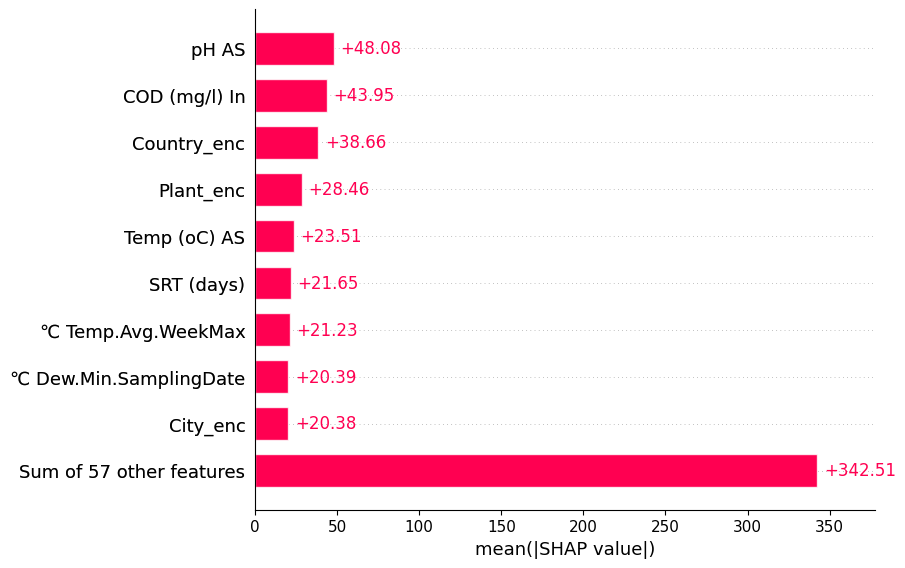

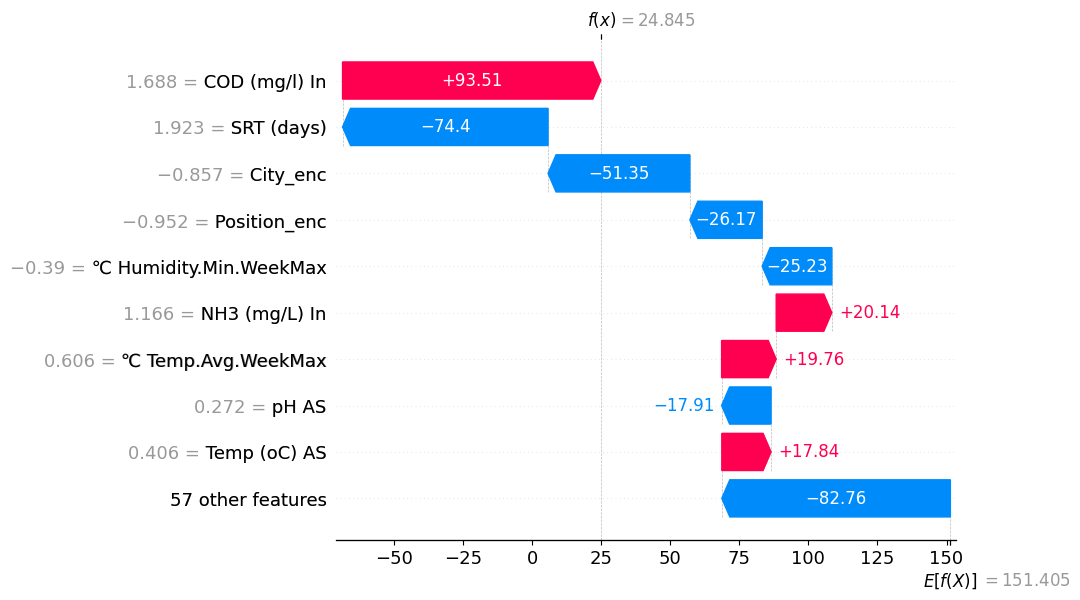

In [14]:
# 전역 feature importance 시각화
shap.plots.bar(shap_values)

# 특정 샘플에 대한 해석 (예: 첫 번째 샘플)
shap.plots.waterfall(shap_values[0])